# MMRotate Image Detection on Drone Imagery

Author: Kirsty Weitzel

## Import Libraries
conda environment path: /gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2

In [1]:
import pandas
import matplotlib.pyplot as plt

In [2]:
!pwd

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01


In [3]:
from mmcv.utils import collect_env

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [4]:
import mmrotate
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset
print(mmrotate.__version__)

0.3.4


In [5]:
# Test mmrotate installation
!mim download mmrotate --config oriented_rcnn_r50_fpn_1x_dota_le90 --dest .

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing oriented_rcnn_r50_fpn_1x_dota_le90...
oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth exists in /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Successfully dumped oriented_rcnn_r50_fpn_1x_dota_le90.py to /gpfs/data/bershteynlab/SatelliteImagery/weitzk01


In [6]:
# Check MMDetection installation
import mmdet
print(mmdet.__version__)

2.28.2


In [7]:
# Check mmcv installation
import mmcv
from mmcv import Config
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

10.2
GCC 7.3


In [8]:
import torch
print(torch.__version__)

1.8.0


In [9]:
from mmcv.utils import collect_env
collect_env()

/bin/sh: gcc: command not found


{'sys.platform': 'linux',
 'Python': '3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]',
 'CUDA available': True,
 'GPU 0': 'Tesla V100-SXM2-16GB',
 'CUDA_HOME': '/gpfs/share/apps/cuda/10.1.105',
 'NVCC': 'Cuda compilation tools, release 10.1, V10.1.10',
 'GCC': 'n/a',
 'PyTorch': '1.8.0',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v1.7.0 (Git Hash 7aed236906b1f7a05c0917e5257a1af05e9ff683)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 10.2\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute_37\n  - CuDNN 

## Explore Data

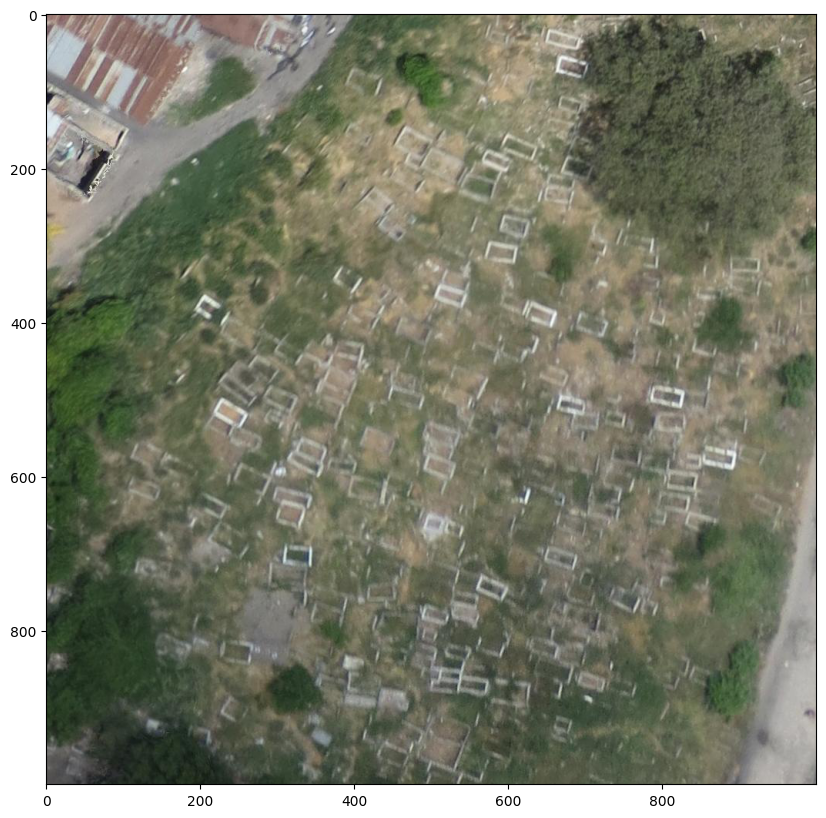

In [10]:
# Let's take a look at the dataset image
img = mmcv.imread('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/DAR_UNLABLED_4_SatelliteImagery_drone_556f7a49ac00a903002fb01e.tif_0_0.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [11]:
# Read in dataset labels as a dataframe
import pandas as pd
img_labels = pd.read_csv('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/train/DAR_UNLABLED_4_SatelliteImagery_drone_556f7a49ac00a903002fb01e.tif_0_0.txt',
            sep=' ',
            names=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'label', 'difficulty'])
img_labels.head()

,x1,y1,x2,y2,x3,y3,x4,y4,label,difficulty
0,652.9,17.7,648.9,32.4,690.2,47.1,694.2,31.1,grave,0
1,664.6,54.3,660.6,68.9,701.9,83.6,705.9,67.6,grave,0
2,395.3,74.3,391.3,88.9,432.6,103.6,436.6,87.6,grave,0
3,660.6,102.3,656.6,116.9,697.9,131.6,701.9,115.6,grave,0
4,597.9,159.6,593.9,174.3,635.3,188.9,639.3,172.9,grave,0


In [12]:
img_labels.shape

(194, 10)

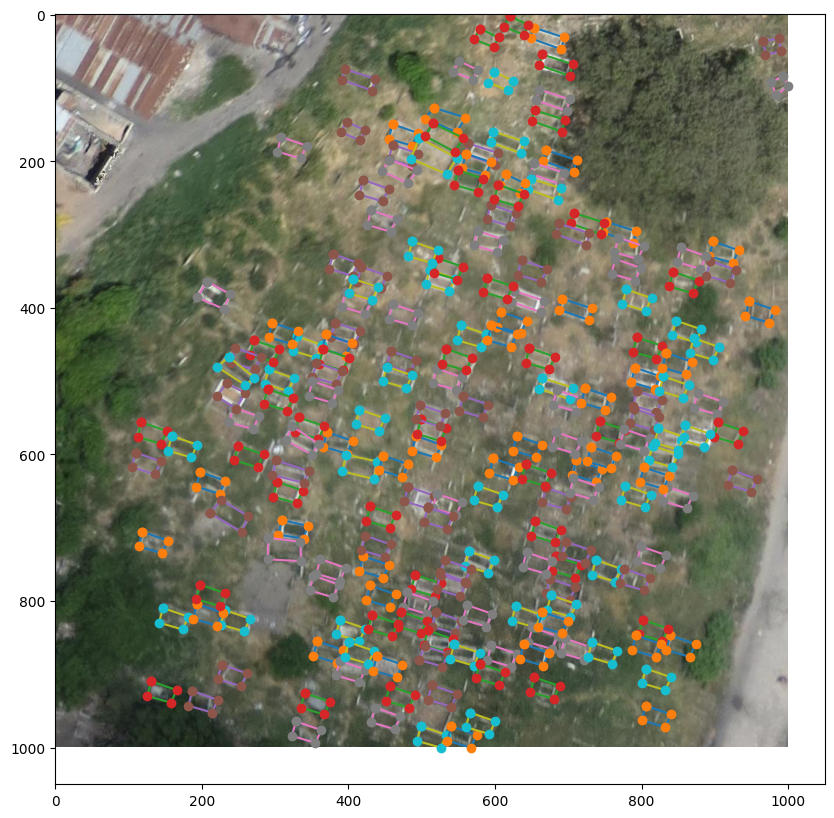

In [13]:
# Let's take a look at the dataset image with overlayed labels
img = mmcv.imread('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/DAR_UNLABLED_4_SatelliteImagery_drone_556f7a49ac00a903002fb01e.tif_0_0.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
for index, row in img_labels.iterrows():
    x = row[['x1', 'x2', 'x3', 'x4', 'x1']]
    y = row[['y1', 'y2', 'y3', 'y4', 'y1']]
    plt.plot(x, y, '-')
    plt.plot(x, y, 'o')
plt.show()

## Create MMRotate config

In [14]:
@ROTATED_DATASETS.register_module()
class DroneDataset(DOTADataset):
    """Grave dataset for detection."""
    CLASSES = ('grave',)

In [15]:
def get_number_of_graves_labeled(file_name, folder_name='val'):
    img_labels = pd.read_csv(f'/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation/{folder_name}/{file_name}.txt',
            sep=' ',
            names=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'label', 'difficulty'])
    num_graves_labeled = img_labels.shape[0]
    return num_graves_labeled

def get_number_of_graves_detected(img_stem, confidence_threshold=.3):
    img = mmcv.imread(f'/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/{img_stem}.png')
    result = inference_detector(model, img)
    num_graves_detected = len(np.where(result[0][:, -1] > confidence_threshold)[0])
    return num_graves_detected

In [ ]:
from mmcv import Config
from mmdet.apis import set_random_seed, inference_detector, show_result_pyplot
import os.path as osp

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

import os
import mmcv
from mmdet.apis import inference_detector
import numpy as np
import pandas as pd
import warnings

confidence_list = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

cemetaries = ["DAR_UNLABLED_1", "DAR_UNLABLED_2", "DAR_UNLABLED_3", "DAR_UNLABLED_4", "DAR_UNLABLED_5", "DAR_UNLABLED_6", "DAR_UNLABLED_7", "Ismail Cementary", "Ismaili Cemetery", "Karume Cemetery", "Mburahati", "Mianzini Graveyard", "Ubungo", "Msasani", "Mikocheni"]

for cemetary in cemetaries:

    # We use mim to download the pre-trained checkpoints for inference and finetuning.
    !mim download mmrotate --config oriented_rcnn_r50_fpn_1x_dota_le90 --dest .
    
    cfg = Config.fromfile('oriented_rcnn_r50_fpn_1x_dota_le90.py')

    # Modify dataset type and path
    cfg.dataset_type = 'DroneDataset'
    cfg.data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
    
    cfg.data.test.type = 'DroneDataset'
    cfg.data.test.data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
    cfg.data.test.ann_file = f'{cemetary}_test'
    cfg.data.test.img_prefix = 'images'
    
    cfg.data.train.type = 'DroneDataset'
    cfg.data.train.data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
    cfg.data.train.ann_file = f'{cemetary}_train'
    cfg.data.train.img_prefix = 'images'
    
    cfg.data.val.type = 'DroneDataset'
    cfg.data.val.data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
    cfg.data.val.ann_file = f'{cemetary}_test'
    cfg.data.val.img_prefix = 'images'
    
    # modify num classes of the model in box head
    cfg.model.roi_head.bbox_head.num_classes = 1
    # We can still use the pre-trained Mask RCNN model
    cfg.load_from = 'oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'
    
    # Set up working dir to save files and logs.
    cfg.work_dir = f'{cemetary}_logs'
    
    cfg.optimizer.lr = 0.001
    cfg.lr_config.warmup = None
    cfg.runner.max_epochs = 100
    cfg.log_config.interval = 10
    
    # Change the evaluation metric since we use customized dataset.
    cfg.evaluation.metric = 'mAP'
    # We can set the evaluation interval to reduce the evaluation times
    cfg.evaluation.interval = 3
    # We can set the checkpoint saving interval to reduce the storage cost
    cfg.checkpoint_config.interval = 3
    
    # Set seed thus the results are more reproducible
    cfg.seed = 0
    set_random_seed(0, deterministic=False)
    cfg.gpu_ids = range(1)
    cfg.device='cuda'
    
    # We can also use tensorboard to log the training process
    cfg.log_config.hooks = [dict(type='TextLoggerHook'), dict(type='TensorboardLoggerHook')]
    
    # We can initialize the logger for training and have a look
    # at the final config used for training
    print(f'Config:\n{cfg.pretty_text}')

    # Build dataset
    datasets = [build_dataset(cfg.data.train)]
    
    # Build the detector
    model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
    # Add an attribute for visualization convenience
    model.CLASSES = datasets[0].CLASSES
    
    # Create work_dir
    mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
    train_detector(model, datasets, cfg, distributed=False, validate=True)

    results = []
    model.cfg = cfg
    
    for confidence_threshold in confidence_list:
        for file_name in os.listdir(f'/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation/{cemetary}_test'):
            img_stem = file_name.replace(".txt", "")
            num_graves_detected = get_number_of_graves_detected(img_stem, confidence_threshold)

            num_graves_labeled = get_number_of_graves_labeled(img_stem, folder_name=f'{cemetary}_test')
            
            results.append({'ModelName': 'MMRotate', 'FileName': img_stem, 'ConfidenceThreshold': confidence_threshold, 'ActualCount': num_graves_labeled, 'PredictedCount': num_graves_detected})

    results_df = pd.DataFrame(results)
    
    results_df['pct_detected'] = results_df['PredictedCount'] / results_df['ActualCount']
    results_df.sort_values("pct_detected", ascending=False)
    results_df.to_csv(f"{cemetary}_crossval_results_updated_v2.csv")

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing oriented_rcnn_r50_fpn_1x_dota_le90...
oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth exists in /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Successfully dumped oriented_rcnn_r50_fpn_1x_dota_le90.py to /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Config:
dataset_type = 'DroneDataset'
data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2024-10-29 17:27:01,438 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-10-29 17:27:01,53

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.1 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:28:48,682 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 815  | 0.575  | 0.491 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.491 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 2.7 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:30:33,232 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 704  | 0.601  | 0.558 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.558 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:32:14,291 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 641  | 0.614  | 0.579 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.579 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.1 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:33:55,169 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 615  | 0.609  | 0.579 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.579 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.1 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:35:37,759 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 614  | 0.609  | 0.580 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.580 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:37:18,731 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 615  | 0.610  | 0.580 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.580 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:38:58,616 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 612  | 0.616  | 0.587 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.587 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:40:41,549 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 612  | 0.610  | 0.579 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.579 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:42:21,566 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 613  | 0.614  | 0.584 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.584 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:44:01,163 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 606  | 0.609  | 0.579 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.579 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.1 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:45:40,140 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 602  | 0.616  | 0.586 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.586 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:47:20,045 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 603  | 0.616  | 0.584 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.584 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:49:00,869 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 604  | 0.614  | 0.583 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.583 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:50:40,390 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 606  | 0.614  | 0.583 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.583 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:52:19,404 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 605  | 0.612  | 0.579 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.579 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 2.7 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:54:00,182 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 604  | 0.610  | 0.579 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.579 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:55:40,763 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 602  | 0.609  | 0.579 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.579 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:57:21,617 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 604  | 0.612  | 0.580 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.580 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 17:59:01,274 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 605  | 0.612  | 0.580 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.580 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.1 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:00:41,216 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 605  | 0.612  | 0.580 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.580 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:02:22,195 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 601  | 0.612  | 0.580 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.580 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:04:02,203 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 607  | 0.614  | 0.581 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.581 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:05:42,200 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 608  | 0.612  | 0.579 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.579 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:07:23,373 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 603  | 0.612  | 0.580 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.580 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:09:05,079 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 609  | 0.612  | 0.579 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.579 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:10:45,396 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 607  | 0.614  | 0.581 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.581 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:12:25,337 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 606  | 0.614  | 0.581 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.581 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.3 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:14:04,747 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 596  | 0.612  | 0.580 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.580 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 2.7 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:15:43,356 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 601  | 0.616  | 0.582 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.582 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.1 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:17:22,347 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 603  | 0.616  | 0.581 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.581 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:19:00,899 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 601  | 0.616  | 0.582 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.582 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:20:39,877 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 603  | 0.616  | 0.582 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.582 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 3.2 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:22:18,864 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 562 | 598  | 0.612  | 0.581 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.581 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing oriented_rcnn_r50_fpn_1x_dota_le90...
oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth exists in /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Successfully dumped oriented_rcnn_r50_fpn_1x_dota_le90.py to /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Config:
dataset_type = 'DroneDataset'
data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2024-10-29 18:23:06,269 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-10-29 18:23:06,32

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.4 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:24:47,474 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 711  | 0.781  | 0.714 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.714 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:26:28,228 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 659  | 0.792  | 0.714 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.714 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:28:07,760 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 611  | 0.790  | 0.715 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.715 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:29:45,916 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 601  | 0.786  | 0.716 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.716 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:31:24,529 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 606  | 0.788  | 0.716 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.716 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:33:02,468 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 603  | 0.786  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:34:41,436 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 603  | 0.788  | 0.716 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.716 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:36:20,276 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 603  | 0.786  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.4 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:37:59,136 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 600  | 0.784  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:39:37,862 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 602  | 0.788  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:41:16,363 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 602  | 0.786  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:42:55,008 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 604  | 0.786  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:44:33,092 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 603  | 0.786  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:46:10,473 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 603  | 0.784  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:47:48,814 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 602  | 0.784  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:49:27,509 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 603  | 0.790  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:51:05,256 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 603  | 0.794  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:52:43,790 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 600  | 0.796  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:54:21,983 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 599  | 0.794  | 0.718 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.718 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:56:00,747 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 599  | 0.792  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:57:39,461 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 600  | 0.792  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 18:59:18,365 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 600  | 0.792  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.4 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:00:57,473 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 600  | 0.794  | 0.718 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.718 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:02:35,889 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 605  | 0.798  | 0.718 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.718 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:04:14,171 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 601  | 0.796  | 0.718 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.718 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:05:52,517 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 603  | 0.800  | 0.778 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.778 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:07:30,274 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 603  | 0.800  | 0.778 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.778 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:09:07,901 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 601  | 0.798  | 0.717 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.717 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:10:46,627 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 600  | 0.798  | 0.718 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.718 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:12:24,462 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 600  | 0.798  | 0.718 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.718 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.0 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:14:02,201 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 600  | 0.798  | 0.718 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.718 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:15:39,697 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 599  | 0.800  | 0.778 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.778 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:17:17,236 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 485 | 599  | 0.800  | 0.778 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.778 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, i

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing oriented_rcnn_r50_fpn_1x_dota_le90...
oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth exists in /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Successfully dumped oriented_rcnn_r50_fpn_1x_dota_le90.py to /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Config:
dataset_type = 'DroneDataset'
data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2024-10-29 19:18:02,014 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-10-29 19:18:02,02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:19:33,929 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 158  | 0.766  | 0.668 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.668 |
+-------+-----+------+--------+-------+
2024-10-29 19:19:33,971 - mmdet - INFO - Epoch(val) [3][1]	mAP: 0.6678
2024-10-29 19:19:41,450 - mmdet - INFO - Epoch [4][10/62]	lr: 1.000e-03, eta: 0:44:10, time: 0.747, data_time: 0.368, memory: 5523, loss_rpn_cls: 0.1289, loss_rpn_bbox: 0.2329, loss_cls: 0.2965, acc: 87.7051, loss_bbox: 0.3089, loss: 0.9672, grad_norm: 4.4143
2024-10-29 19:19:45,222 - mmdet - INFO - Epoch [4][20/62]	lr: 1.000e-03, eta: 0:43:47, time: 0.377, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.1091, loss_rpn_bbox: 0.2263, loss_cls: 0.2663, acc: 88.7988, loss_bbox: 0.2751, loss: 0.8768, grad_norm: 3.3521
2024-10-29 19:19:48,800 - mmdet - INFO - Epoch [4][30/62]	lr: 1.000e-03, eta: 0:43:20, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:21:04,731 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 125  | 0.797  | 0.689 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.689 |
+-------+-----+------+--------+-------+
2024-10-29 19:21:04,774 - mmdet - INFO - Epoch(val) [6][1]	mAP: 0.6891
2024-10-29 19:21:12,247 - mmdet - INFO - Epoch [7][10/62]	lr: 1.000e-03, eta: 0:41:57, time: 0.746, data_time: 0.361, memory: 5523, loss_rpn_cls: 0.0916, loss_rpn_bbox: 0.1911, loss_cls: 0.2629, acc: 89.5508, loss_bbox: 0.2754, loss: 0.8210, grad_norm: 3.7356
2024-10-29 19:21:16,015 - mmdet - INFO - Epoch [7][20/62]	lr: 1.000e-03, eta: 0:41:44, time: 0.377, data_time: 0.012, memory: 5523, loss_rpn_cls: 0.0950, loss_rpn_bbox: 0.2262, loss_cls: 0.2331, acc: 90.0879, loss_bbox: 0.2831, loss: 0.8374, grad_norm: 3.3432
2024-10-29 19:21:19,583 - mmdet - INFO - Epoch [7][30/62]	lr: 1.000e-03, eta: 0:41:29, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:22:36,300 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 126  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:22:36,343 - mmdet - INFO - Epoch(val) [9][1]	mAP: 0.6902
2024-10-29 19:22:43,935 - mmdet - INFO - Epoch [10][10/62]	lr: 1.000e-04, eta: 0:40:32, time: 0.758, data_time: 0.360, memory: 5523, loss_rpn_cls: 0.0963, loss_rpn_bbox: 0.2142, loss_cls: 0.2286, acc: 90.2832, loss_bbox: 0.2655, loss: 0.8046, grad_norm: 3.2281
2024-10-29 19:22:47,738 - mmdet - INFO - Epoch [10][20/62]	lr: 1.000e-04, eta: 0:40:22, time: 0.380, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0848, loss_rpn_bbox: 0.2054, loss_cls: 0.2604, acc: 88.9453, loss_bbox: 0.2737, loss: 0.8243, grad_norm: 3.3823
2024-10-29 19:22:51,388 - mmdet - INFO - Epoch [10][30/62]	lr: 1.000e-04, eta: 0:40:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:24:07,611 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 129  | 0.797  | 0.694 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.694 |
+-------+-----+------+--------+-------+
2024-10-29 19:24:07,654 - mmdet - INFO - Epoch(val) [12][1]	mAP: 0.6941
2024-10-29 19:24:15,228 - mmdet - INFO - Epoch [13][10/62]	lr: 1.000e-05, eta: 0:39:06, time: 0.756, data_time: 0.362, memory: 5523, loss_rpn_cls: 0.0678, loss_rpn_bbox: 0.1752, loss_cls: 0.2094, acc: 90.9473, loss_bbox: 0.2349, loss: 0.6873, grad_norm: 2.7595
2024-10-29 19:24:18,724 - mmdet - INFO - Epoch [13][20/62]	lr: 1.000e-05, eta: 0:38:56, time: 0.350, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0760, loss_rpn_bbox: 0.1604, loss_cls: 0.2429, acc: 89.8730, loss_bbox: 0.2847, loss: 0.7640, grad_norm: 3.5803
2024-10-29 19:24:22,454 - mmdet - INFO - Epoch [13][30/62]	lr: 1.000e-05, eta: 0:38:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:25:38,468 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 126  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:25:38,511 - mmdet - INFO - Epoch(val) [15][1]	mAP: 0.6904
2024-10-29 19:25:45,919 - mmdet - INFO - Epoch [16][10/62]	lr: 1.000e-05, eta: 0:37:40, time: 0.739, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.0698, loss_rpn_bbox: 0.2115, loss_cls: 0.2279, acc: 90.7129, loss_bbox: 0.2679, loss: 0.7771, grad_norm: 3.2676
2024-10-29 19:25:49,710 - mmdet - INFO - Epoch [16][20/62]	lr: 1.000e-05, eta: 0:37:32, time: 0.379, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0785, loss_rpn_bbox: 0.1950, loss_cls: 0.2216, acc: 90.7812, loss_bbox: 0.2793, loss: 0.7744, grad_norm: 3.3166
2024-10-29 19:25:53,540 - mmdet - INFO - Epoch [16][30/62]	lr: 1.000e-05, eta: 0:37:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:27:10,518 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 126  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:27:10,561 - mmdet - INFO - Epoch(val) [18][1]	mAP: 0.6904
2024-10-29 19:27:17,977 - mmdet - INFO - Epoch [19][10/62]	lr: 1.000e-05, eta: 0:36:17, time: 0.740, data_time: 0.360, memory: 5523, loss_rpn_cls: 0.0624, loss_rpn_bbox: 0.1855, loss_cls: 0.2095, acc: 91.6504, loss_bbox: 0.2531, loss: 0.7105, grad_norm: 3.3692
2024-10-29 19:27:21,642 - mmdet - INFO - Epoch [19][20/62]	lr: 1.000e-05, eta: 0:36:10, time: 0.366, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0803, loss_rpn_bbox: 0.2020, loss_cls: 0.2251, acc: 90.3223, loss_bbox: 0.2506, loss: 0.7579, grad_norm: 3.0875
2024-10-29 19:27:25,411 - mmdet - INFO - Epoch [19][30/62]	lr: 1.000e-05, eta: 0:36:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:28:41,977 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 126  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:28:42,020 - mmdet - INFO - Epoch(val) [21][1]	mAP: 0.6904
2024-10-29 19:28:49,464 - mmdet - INFO - Epoch [22][10/62]	lr: 1.000e-05, eta: 0:34:55, time: 0.743, data_time: 0.362, memory: 5523, loss_rpn_cls: 0.0674, loss_rpn_bbox: 0.1605, loss_cls: 0.2501, acc: 89.5410, loss_bbox: 0.2789, loss: 0.7570, grad_norm: 3.4194
2024-10-29 19:28:53,189 - mmdet - INFO - Epoch [22][20/62]	lr: 1.000e-05, eta: 0:34:49, time: 0.372, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0684, loss_rpn_bbox: 0.1478, loss_cls: 0.2455, acc: 89.6289, loss_bbox: 0.2735, loss: 0.7352, grad_norm: 3.3653
2024-10-29 19:28:56,809 - mmdet - INFO - Epoch [22][30/62]	lr: 1.000e-05, eta: 0:34:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:30:13,129 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 128  | 0.781  | 0.693 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.693 |
+-------+-----+------+--------+-------+
2024-10-29 19:30:13,172 - mmdet - INFO - Epoch(val) [24][1]	mAP: 0.6926
2024-10-29 19:30:20,768 - mmdet - INFO - Epoch [25][10/62]	lr: 1.000e-05, eta: 0:33:34, time: 0.758, data_time: 0.366, memory: 5523, loss_rpn_cls: 0.0948, loss_rpn_bbox: 0.1889, loss_cls: 0.2282, acc: 90.5078, loss_bbox: 0.2775, loss: 0.7894, grad_norm: 3.2249
2024-10-29 19:30:24,576 - mmdet - INFO - Epoch [25][20/62]	lr: 1.000e-05, eta: 0:33:29, time: 0.381, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0732, loss_rpn_bbox: 0.1913, loss_cls: 0.2460, acc: 89.7656, loss_bbox: 0.2643, loss: 0.7748, grad_norm: 3.6278
2024-10-29 19:30:28,345 - mmdet - INFO - Epoch [25][30/62]	lr: 1.000e-05, eta: 0:33:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:31:44,420 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.692 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.692 |
+-------+-----+------+--------+-------+
2024-10-29 19:31:44,463 - mmdet - INFO - Epoch(val) [27][1]	mAP: 0.6923
2024-10-29 19:31:51,971 - mmdet - INFO - Epoch [28][10/62]	lr: 1.000e-05, eta: 0:32:14, time: 0.749, data_time: 0.360, memory: 5523, loss_rpn_cls: 0.0569, loss_rpn_bbox: 0.1754, loss_cls: 0.2245, acc: 91.1133, loss_bbox: 0.2325, loss: 0.6893, grad_norm: 3.2497
2024-10-29 19:31:55,725 - mmdet - INFO - Epoch [28][20/62]	lr: 1.000e-05, eta: 0:32:08, time: 0.375, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0869, loss_rpn_bbox: 0.1688, loss_cls: 0.2228, acc: 90.8008, loss_bbox: 0.2481, loss: 0.7266, grad_norm: 3.4844
2024-10-29 19:31:59,549 - mmdet - INFO - Epoch [28][30/62]	lr: 1.000e-05, eta: 0:32:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:33:15,469 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.693 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.693 |
+-------+-----+------+--------+-------+
2024-10-29 19:33:15,511 - mmdet - INFO - Epoch(val) [30][1]	mAP: 0.6926
2024-10-29 19:33:22,986 - mmdet - INFO - Epoch [31][10/62]	lr: 1.000e-05, eta: 0:30:53, time: 0.746, data_time: 0.365, memory: 5523, loss_rpn_cls: 0.0853, loss_rpn_bbox: 0.1707, loss_cls: 0.2397, acc: 89.5801, loss_bbox: 0.2719, loss: 0.7675, grad_norm: 3.3024
2024-10-29 19:33:26,581 - mmdet - INFO - Epoch [31][20/62]	lr: 1.000e-05, eta: 0:30:47, time: 0.360, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0761, loss_rpn_bbox: 0.2475, loss_cls: 0.2401, acc: 89.6875, loss_bbox: 0.2730, loss: 0.8367, grad_norm: 3.6228
2024-10-29 19:33:30,285 - mmdet - INFO - Epoch [31][30/62]	lr: 1.000e-05, eta: 0:30:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:34:47,302 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.689 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.689 |
+-------+-----+------+--------+-------+
2024-10-29 19:34:47,345 - mmdet - INFO - Epoch(val) [33][1]	mAP: 0.6888
2024-10-29 19:34:54,694 - mmdet - INFO - Epoch [34][10/62]	lr: 1.000e-05, eta: 0:29:33, time: 0.734, data_time: 0.363, memory: 5523, loss_rpn_cls: 0.0683, loss_rpn_bbox: 0.1886, loss_cls: 0.2485, acc: 89.6484, loss_bbox: 0.3084, loss: 0.8138, grad_norm: 3.4207
2024-10-29 19:34:58,508 - mmdet - INFO - Epoch [34][20/62]	lr: 1.000e-05, eta: 0:29:27, time: 0.381, data_time: 0.016, memory: 5523, loss_rpn_cls: 0.0882, loss_rpn_bbox: 0.2059, loss_cls: 0.2106, acc: 90.9277, loss_bbox: 0.2495, loss: 0.7541, grad_norm: 3.4038
2024-10-29 19:35:02,180 - mmdet - INFO - Epoch [34][30/62]	lr: 1.000e-05, eta: 0:29:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.7 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:36:18,149 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.689 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.689 |
+-------+-----+------+--------+-------+
2024-10-29 19:36:18,191 - mmdet - INFO - Epoch(val) [36][1]	mAP: 0.6892
2024-10-29 19:36:25,611 - mmdet - INFO - Epoch [37][10/62]	lr: 1.000e-05, eta: 0:28:12, time: 0.741, data_time: 0.357, memory: 5523, loss_rpn_cls: 0.0638, loss_rpn_bbox: 0.1731, loss_cls: 0.2243, acc: 90.1660, loss_bbox: 0.2658, loss: 0.7270, grad_norm: 2.9189
2024-10-29 19:36:29,352 - mmdet - INFO - Epoch [37][20/62]	lr: 1.000e-05, eta: 0:28:07, time: 0.374, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0870, loss_rpn_bbox: 0.2671, loss_cls: 0.2103, acc: 91.1914, loss_bbox: 0.2321, loss: 0.7964, grad_norm: 3.4425
2024-10-29 19:36:33,090 - mmdet - INFO - Epoch [37][30/62]	lr: 1.000e-05, eta: 0:28:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:37:48,850 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:37:48,892 - mmdet - INFO - Epoch(val) [39][1]	mAP: 0.6900
2024-10-29 19:37:56,330 - mmdet - INFO - Epoch [40][10/62]	lr: 1.000e-05, eta: 0:26:51, time: 0.742, data_time: 0.362, memory: 5523, loss_rpn_cls: 0.0747, loss_rpn_bbox: 0.2048, loss_cls: 0.2309, acc: 89.6094, loss_bbox: 0.2643, loss: 0.7747, grad_norm: 3.5136
2024-10-29 19:38:00,138 - mmdet - INFO - Epoch [40][20/62]	lr: 1.000e-05, eta: 0:26:46, time: 0.381, data_time: 0.022, memory: 5523, loss_rpn_cls: 0.0701, loss_rpn_bbox: 0.2030, loss_cls: 0.2425, acc: 89.4629, loss_bbox: 0.2792, loss: 0.7947, grad_norm: 3.4844
2024-10-29 19:38:04,051 - mmdet - INFO - Epoch [40][30/62]	lr: 1.000e-05, eta: 0:26:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:39:19,935 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 129  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:39:19,978 - mmdet - INFO - Epoch(val) [42][1]	mAP: 0.6900
2024-10-29 19:39:27,442 - mmdet - INFO - Epoch [43][10/62]	lr: 1.000e-05, eta: 0:25:32, time: 0.745, data_time: 0.360, memory: 5523, loss_rpn_cls: 0.0708, loss_rpn_bbox: 0.1593, loss_cls: 0.2200, acc: 90.6445, loss_bbox: 0.2557, loss: 0.7058, grad_norm: 3.0150
2024-10-29 19:39:31,082 - mmdet - INFO - Epoch [43][20/62]	lr: 1.000e-05, eta: 0:25:27, time: 0.364, data_time: 0.017, memory: 5523, loss_rpn_cls: 0.0614, loss_rpn_bbox: 0.1820, loss_cls: 0.2226, acc: 90.4492, loss_bbox: 0.2804, loss: 0.7465, grad_norm: 2.9353
2024-10-29 19:39:34,784 - mmdet - INFO - Epoch [43][30/62]	lr: 1.000e-05, eta: 0:25:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:40:51,323 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:40:51,365 - mmdet - INFO - Epoch(val) [45][1]	mAP: 0.6904
2024-10-29 19:40:58,887 - mmdet - INFO - Epoch [46][10/62]	lr: 1.000e-05, eta: 0:24:13, time: 0.751, data_time: 0.356, memory: 5523, loss_rpn_cls: 0.0755, loss_rpn_bbox: 0.1523, loss_cls: 0.2547, acc: 88.9941, loss_bbox: 0.2823, loss: 0.7648, grad_norm: 3.2684
2024-10-29 19:41:02,636 - mmdet - INFO - Epoch [46][20/62]	lr: 1.000e-05, eta: 0:24:08, time: 0.375, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0588, loss_rpn_bbox: 0.1500, loss_cls: 0.2149, acc: 90.8594, loss_bbox: 0.2264, loss: 0.6501, grad_norm: 2.8498
2024-10-29 19:41:06,366 - mmdet - INFO - Epoch [46][30/62]	lr: 1.000e-05, eta: 0:24:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:42:22,401 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 128  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:42:22,444 - mmdet - INFO - Epoch(val) [48][1]	mAP: 0.6904
2024-10-29 19:42:29,821 - mmdet - INFO - Epoch [49][10/62]	lr: 1.000e-05, eta: 0:22:53, time: 0.736, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.0662, loss_rpn_bbox: 0.1820, loss_cls: 0.2442, acc: 88.8770, loss_bbox: 0.2843, loss: 0.7768, grad_norm: 3.3545
2024-10-29 19:42:33,579 - mmdet - INFO - Epoch [49][20/62]	lr: 1.000e-05, eta: 0:22:49, time: 0.376, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0851, loss_rpn_bbox: 0.2128, loss_cls: 0.2079, acc: 91.9531, loss_bbox: 0.2465, loss: 0.7523, grad_norm: 3.5869
2024-10-29 19:42:37,141 - mmdet - INFO - Epoch [49][30/62]	lr: 1.000e-05, eta: 0:22:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:43:54,734 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.797  | 0.692 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.692 |
+-------+-----+------+--------+-------+
2024-10-29 19:43:54,777 - mmdet - INFO - Epoch(val) [51][1]	mAP: 0.6916
2024-10-29 19:44:02,238 - mmdet - INFO - Epoch [52][10/62]	lr: 1.000e-05, eta: 0:21:34, time: 0.745, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.0601, loss_rpn_bbox: 0.1797, loss_cls: 0.2013, acc: 91.5039, loss_bbox: 0.2507, loss: 0.6918, grad_norm: 2.8188
2024-10-29 19:44:05,992 - mmdet - INFO - Epoch [52][20/62]	lr: 1.000e-05, eta: 0:21:29, time: 0.375, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0784, loss_rpn_bbox: 0.2032, loss_cls: 0.2319, acc: 90.5273, loss_bbox: 0.2786, loss: 0.7921, grad_norm: 3.3345
2024-10-29 19:44:09,762 - mmdet - INFO - Epoch [52][30/62]	lr: 1.000e-05, eta: 0:21:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:45:26,707 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:45:26,750 - mmdet - INFO - Epoch(val) [54][1]	mAP: 0.6904
2024-10-29 19:45:34,194 - mmdet - INFO - Epoch [55][10/62]	lr: 1.000e-05, eta: 0:20:14, time: 0.743, data_time: 0.360, memory: 5523, loss_rpn_cls: 0.0573, loss_rpn_bbox: 0.1297, loss_cls: 0.2140, acc: 90.6641, loss_bbox: 0.2348, loss: 0.6358, grad_norm: 3.5996
2024-10-29 19:45:37,931 - mmdet - INFO - Epoch [55][20/62]	lr: 1.000e-05, eta: 0:20:09, time: 0.374, data_time: 0.010, memory: 5523, loss_rpn_cls: 0.0932, loss_rpn_bbox: 0.1963, loss_cls: 0.2249, acc: 90.9180, loss_bbox: 0.2651, loss: 0.7795, grad_norm: 3.2670
2024-10-29 19:45:41,770 - mmdet - INFO - Epoch [55][30/62]	lr: 1.000e-05, eta: 0:20:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:46:58,891 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:46:58,933 - mmdet - INFO - Epoch(val) [57][1]	mAP: 0.6900
2024-10-29 19:47:06,444 - mmdet - INFO - Epoch [58][10/62]	lr: 1.000e-05, eta: 0:18:55, time: 0.750, data_time: 0.357, memory: 5523, loss_rpn_cls: 0.0928, loss_rpn_bbox: 0.1822, loss_cls: 0.2377, acc: 89.6094, loss_bbox: 0.2660, loss: 0.7787, grad_norm: 3.1742
2024-10-29 19:47:10,136 - mmdet - INFO - Epoch [58][20/62]	lr: 1.000e-05, eta: 0:18:50, time: 0.369, data_time: 0.017, memory: 5523, loss_rpn_cls: 0.0772, loss_rpn_bbox: 0.1949, loss_cls: 0.2039, acc: 91.8066, loss_bbox: 0.2277, loss: 0.7037, grad_norm: 3.2202
2024-10-29 19:47:14,076 - mmdet - INFO - Epoch [58][30/62]	lr: 1.000e-05, eta: 0:18:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 19:48:30,618 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.688 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.688 |
+-------+-----+------+--------+-------+
2024-10-29 19:48:30,661 - mmdet - INFO - Epoch(val) [60][1]	mAP: 0.6880
2024-10-29 19:48:38,131 - mmdet - INFO - Epoch [61][10/62]	lr: 1.000e-05, eta: 0:17:35, time: 0.746, data_time: 0.361, memory: 5523, loss_rpn_cls: 0.0677, loss_rpn_bbox: 0.1630, loss_cls: 0.2145, acc: 91.6602, loss_bbox: 0.2440, loss: 0.6892, grad_norm: 3.4467
2024-10-29 19:48:41,851 - mmdet - INFO - Epoch [61][20/62]	lr: 1.000e-05, eta: 0:17:30, time: 0.372, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0863, loss_rpn_bbox: 0.1885, loss_cls: 0.2395, acc: 89.5410, loss_bbox: 0.2629, loss: 0.7771, grad_norm: 3.5503
2024-10-29 19:48:45,514 - mmdet - INFO - Epoch [61][30/62]	lr: 1.000e-05, eta: 0:17:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:50:01,360 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 128  | 0.781  | 0.690 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.690 |
+-------+-----+------+--------+-------+
2024-10-29 19:50:01,403 - mmdet - INFO - Epoch(val) [63][1]	mAP: 0.6900
2024-10-29 19:50:08,843 - mmdet - INFO - Epoch [64][10/62]	lr: 1.000e-05, eta: 0:16:15, time: 0.743, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.0750, loss_rpn_bbox: 0.1423, loss_cls: 0.2014, acc: 91.6504, loss_bbox: 0.2352, loss: 0.6539, grad_norm: 2.9602
2024-10-29 19:50:12,477 - mmdet - INFO - Epoch [64][20/62]	lr: 1.000e-05, eta: 0:16:10, time: 0.363, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0762, loss_rpn_bbox: 0.2042, loss_cls: 0.2581, acc: 89.1699, loss_bbox: 0.2973, loss: 0.8357, grad_norm: 3.9295
2024-10-29 19:50:16,366 - mmdet - INFO - Epoch [64][30/62]	lr: 1.000e-05, eta: 0:16:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:51:32,302 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.689 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.689 |
+-------+-----+------+--------+-------+
2024-10-29 19:51:32,346 - mmdet - INFO - Epoch(val) [66][1]	mAP: 0.6888
2024-10-29 19:51:39,674 - mmdet - INFO - Epoch [67][10/62]	lr: 1.000e-05, eta: 0:14:55, time: 0.731, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.0575, loss_rpn_bbox: 0.1879, loss_cls: 0.2184, acc: 90.4395, loss_bbox: 0.2657, loss: 0.7295, grad_norm: 3.1169
2024-10-29 19:51:43,248 - mmdet - INFO - Epoch [67][20/62]	lr: 1.000e-05, eta: 0:14:51, time: 0.357, data_time: 0.012, memory: 5523, loss_rpn_cls: 0.0576, loss_rpn_bbox: 0.1762, loss_cls: 0.2418, acc: 89.6387, loss_bbox: 0.2830, loss: 0.7586, grad_norm: 3.5973
2024-10-29 19:51:47,233 - mmdet - INFO - Epoch [67][30/62]	lr: 1.000e-05, eta: 0:14:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:53:02,918 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.797  | 0.691 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.691 |
+-------+-----+------+--------+-------+
2024-10-29 19:53:02,961 - mmdet - INFO - Epoch(val) [69][1]	mAP: 0.6913
2024-10-29 19:53:10,406 - mmdet - INFO - Epoch [70][10/62]	lr: 1.000e-05, eta: 0:13:36, time: 0.743, data_time: 0.364, memory: 5523, loss_rpn_cls: 0.0724, loss_rpn_bbox: 0.1908, loss_cls: 0.2340, acc: 90.0195, loss_bbox: 0.2711, loss: 0.7683, grad_norm: 3.6061
2024-10-29 19:53:14,025 - mmdet - INFO - Epoch [70][20/62]	lr: 1.000e-05, eta: 0:13:31, time: 0.362, data_time: 0.012, memory: 5523, loss_rpn_cls: 0.0791, loss_rpn_bbox: 0.1789, loss_cls: 0.2349, acc: 89.9219, loss_bbox: 0.2604, loss: 0.7532, grad_norm: 3.4123
2024-10-29 19:53:17,706 - mmdet - INFO - Epoch [70][30/62]	lr: 1.000e-05, eta: 0:13:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:54:33,749 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 126  | 0.797  | 0.693 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.693 |
+-------+-----+------+--------+-------+
2024-10-29 19:54:33,792 - mmdet - INFO - Epoch(val) [72][1]	mAP: 0.6926
2024-10-29 19:54:41,416 - mmdet - INFO - Epoch [73][10/62]	lr: 1.000e-05, eta: 0:12:17, time: 0.761, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.1024, loss_rpn_bbox: 0.2779, loss_cls: 0.2509, acc: 89.6777, loss_bbox: 0.2919, loss: 0.9231, grad_norm: 4.7381
2024-10-29 19:54:44,966 - mmdet - INFO - Epoch [73][20/62]	lr: 1.000e-05, eta: 0:12:12, time: 0.355, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0541, loss_rpn_bbox: 0.1019, loss_cls: 0.2367, acc: 89.5898, loss_bbox: 0.2678, loss: 0.6605, grad_norm: 3.1225
2024-10-29 19:54:48,660 - mmdet - INFO - Epoch [73][30/62]	lr: 1.000e-05, eta: 0:12:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:56:04,867 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 126  | 0.797  | 0.691 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.691 |
+-------+-----+------+--------+-------+
2024-10-29 19:56:04,909 - mmdet - INFO - Epoch(val) [75][1]	mAP: 0.6907
2024-10-29 19:56:12,305 - mmdet - INFO - Epoch [76][10/62]	lr: 1.000e-05, eta: 0:10:57, time: 0.738, data_time: 0.359, memory: 5523, loss_rpn_cls: 0.0734, loss_rpn_bbox: 0.1972, loss_cls: 0.2490, acc: 89.3457, loss_bbox: 0.2641, loss: 0.7837, grad_norm: 3.8576
2024-10-29 19:56:16,068 - mmdet - INFO - Epoch [76][20/62]	lr: 1.000e-05, eta: 0:10:53, time: 0.376, data_time: 0.016, memory: 5523, loss_rpn_cls: 0.0699, loss_rpn_bbox: 0.1987, loss_cls: 0.2184, acc: 90.4883, loss_bbox: 0.2605, loss: 0.7475, grad_norm: 3.2866
2024-10-29 19:56:19,714 - mmdet - INFO - Epoch [76][30/62]	lr: 1.000e-05, eta: 0:10:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:57:36,072 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 126  | 0.797  | 0.691 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.691 |
+-------+-----+------+--------+-------+
2024-10-29 19:57:36,115 - mmdet - INFO - Epoch(val) [78][1]	mAP: 0.6913
2024-10-29 19:57:43,734 - mmdet - INFO - Epoch [79][10/62]	lr: 1.000e-05, eta: 0:09:38, time: 0.761, data_time: 0.360, memory: 5523, loss_rpn_cls: 0.0825, loss_rpn_bbox: 0.1869, loss_cls: 0.2281, acc: 90.6641, loss_bbox: 0.2430, loss: 0.7404, grad_norm: 3.3500
2024-10-29 19:57:47,466 - mmdet - INFO - Epoch [79][20/62]	lr: 1.000e-05, eta: 0:09:33, time: 0.373, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0688, loss_rpn_bbox: 0.1845, loss_cls: 0.2269, acc: 89.9805, loss_bbox: 0.2865, loss: 0.7668, grad_norm: 3.5675
2024-10-29 19:57:51,229 - mmdet - INFO - Epoch [79][30/62]	lr: 1.000e-05, eta: 0:09:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 19:59:07,476 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.689 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.689 |
+-------+-----+------+--------+-------+
2024-10-29 19:59:07,518 - mmdet - INFO - Epoch(val) [81][1]	mAP: 0.6892
2024-10-29 19:59:14,917 - mmdet - INFO - Epoch [82][10/62]	lr: 1.000e-05, eta: 0:08:18, time: 0.738, data_time: 0.360, memory: 5523, loss_rpn_cls: 0.0535, loss_rpn_bbox: 0.1443, loss_cls: 0.2187, acc: 90.7227, loss_bbox: 0.2578, loss: 0.6743, grad_norm: 3.0569
2024-10-29 19:59:18,694 - mmdet - INFO - Epoch [82][20/62]	lr: 1.000e-05, eta: 0:08:14, time: 0.378, data_time: 0.016, memory: 5523, loss_rpn_cls: 0.0679, loss_rpn_bbox: 0.1612, loss_cls: 0.2250, acc: 90.6836, loss_bbox: 0.2408, loss: 0.6949, grad_norm: 2.8010
2024-10-29 19:59:22,518 - mmdet - INFO - Epoch [82][30/62]	lr: 1.000e-05, eta: 0:08:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.4 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:00:40,365 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 126  | 0.797  | 0.691 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.691 |
+-------+-----+------+--------+-------+
2024-10-29 20:00:40,408 - mmdet - INFO - Epoch(val) [84][1]	mAP: 0.6907
2024-10-29 20:00:47,907 - mmdet - INFO - Epoch [85][10/62]	lr: 1.000e-05, eta: 0:06:59, time: 0.749, data_time: 0.357, memory: 5523, loss_rpn_cls: 0.0640, loss_rpn_bbox: 0.1750, loss_cls: 0.2274, acc: 90.1465, loss_bbox: 0.2636, loss: 0.7300, grad_norm: 3.4866
2024-10-29 20:00:51,627 - mmdet - INFO - Epoch [85][20/62]	lr: 1.000e-05, eta: 0:06:55, time: 0.372, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0689, loss_rpn_bbox: 0.2352, loss_cls: 0.2425, acc: 89.9805, loss_bbox: 0.2950, loss: 0.8416, grad_norm: 3.6367
2024-10-29 20:00:55,374 - mmdet - INFO - Epoch [85][30/62]	lr: 1.000e-05, eta: 0:06:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:02:12,758 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 126  | 0.781  | 0.689 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.689 |
+-------+-----+------+--------+-------+
2024-10-29 20:02:12,801 - mmdet - INFO - Epoch(val) [87][1]	mAP: 0.6892
2024-10-29 20:02:20,190 - mmdet - INFO - Epoch [88][10/62]	lr: 1.000e-05, eta: 0:05:39, time: 0.736, data_time: 0.359, memory: 5523, loss_rpn_cls: 0.0739, loss_rpn_bbox: 0.1730, loss_cls: 0.2225, acc: 90.6055, loss_bbox: 0.2545, loss: 0.7239, grad_norm: 3.3330
2024-10-29 20:02:23,964 - mmdet - INFO - Epoch [88][20/62]	lr: 1.000e-05, eta: 0:05:35, time: 0.377, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0738, loss_rpn_bbox: 0.1442, loss_cls: 0.2411, acc: 90.0195, loss_bbox: 0.2797, loss: 0.7388, grad_norm: 3.2295
2024-10-29 20:02:27,671 - mmdet - INFO - Epoch [88][30/62]	lr: 1.000e-05, eta: 0:05:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:03:44,528 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.781  | 0.691 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.691 |
+-------+-----+------+--------+-------+
2024-10-29 20:03:44,571 - mmdet - INFO - Epoch(val) [90][1]	mAP: 0.6910
2024-10-29 20:03:51,942 - mmdet - INFO - Epoch [91][10/62]	lr: 1.000e-05, eta: 0:04:20, time: 0.736, data_time: 0.361, memory: 5523, loss_rpn_cls: 0.0519, loss_rpn_bbox: 0.1949, loss_cls: 0.2438, acc: 89.7363, loss_bbox: 0.3137, loss: 0.8043, grad_norm: 3.5386
2024-10-29 20:03:55,850 - mmdet - INFO - Epoch [91][20/62]	lr: 1.000e-05, eta: 0:04:16, time: 0.391, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0959, loss_rpn_bbox: 0.2556, loss_cls: 0.2385, acc: 89.5410, loss_bbox: 0.2821, loss: 0.8721, grad_norm: 3.4274
2024-10-29 20:03:59,629 - mmdet - INFO - Epoch [91][30/62]	lr: 1.000e-05, eta: 0:04:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:05:15,665 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.797  | 0.691 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.691 |
+-------+-----+------+--------+-------+
2024-10-29 20:05:15,707 - mmdet - INFO - Epoch(val) [93][1]	mAP: 0.6913
2024-10-29 20:05:23,138 - mmdet - INFO - Epoch [94][10/62]	lr: 1.000e-05, eta: 0:03:01, time: 0.742, data_time: 0.357, memory: 5523, loss_rpn_cls: 0.0643, loss_rpn_bbox: 0.1448, loss_cls: 0.2225, acc: 90.4492, loss_bbox: 0.2408, loss: 0.6724, grad_norm: 3.3446
2024-10-29 20:05:26,872 - mmdet - INFO - Epoch [94][20/62]	lr: 1.000e-05, eta: 0:02:56, time: 0.373, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0783, loss_rpn_bbox: 0.2298, loss_cls: 0.2655, acc: 88.6621, loss_bbox: 0.2825, loss: 0.8561, grad_norm: 3.1574
2024-10-29 20:05:30,581 - mmdet - INFO - Epoch [94][30/62]	lr: 1.000e-05, eta: 0:02:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:06:46,528 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 125  | 0.797  | 0.693 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.693 |
+-------+-----+------+--------+-------+
2024-10-29 20:06:46,572 - mmdet - INFO - Epoch(val) [96][1]	mAP: 0.6926
2024-10-29 20:06:53,972 - mmdet - INFO - Epoch [97][10/62]	lr: 1.000e-05, eta: 0:01:41, time: 0.739, data_time: 0.353, memory: 5523, loss_rpn_cls: 0.0612, loss_rpn_bbox: 0.1603, loss_cls: 0.2325, acc: 90.4004, loss_bbox: 0.2638, loss: 0.7177, grad_norm: 3.4652
2024-10-29 20:06:57,783 - mmdet - INFO - Epoch [97][20/62]	lr: 1.000e-05, eta: 0:01:37, time: 0.381, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0688, loss_rpn_bbox: 0.1858, loss_cls: 0.2064, acc: 91.3086, loss_bbox: 0.2352, loss: 0.6962, grad_norm: 3.3649
2024-10-29 20:07:01,446 - mmdet - INFO - Epoch [97][30/62]	lr: 1.000e-05, eta: 0:01:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:08:17,330 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 64  | 127  | 0.797  | 0.691 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.691 |
+-------+-----+------+--------+-------+
2024-10-29 20:08:17,373 - mmdet - INFO - Epoch(val) [99][1]	mAP: 0.6913
2024-10-29 20:08:24,698 - mmdet - INFO - Epoch [100][10/62]	lr: 1.000e-05, eta: 0:00:22, time: 0.731, data_time: 0.354, memory: 5523, loss_rpn_cls: 0.0573, loss_rpn_bbox: 0.1244, loss_cls: 0.2205, acc: 90.9863, loss_bbox: 0.2572, loss: 0.6594, grad_norm: 3.0397
2024-10-29 20:08:28,361 - mmdet - INFO - Epoch [100][20/62]	lr: 1.000e-05, eta: 0:00:17, time: 0.366, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0654, loss_rpn_bbox: 0.1520, loss_cls: 0.2368, acc: 89.9902, loss_bbox: 0.2758, loss: 0.7300, grad_norm: 3.1526
2024-10-29 20:08:32,351 - mmdet - INFO - Epoch [100][30/62]	lr: 1.000e-05, eta: 0:

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing oriented_rcnn_r50_fpn_1x_dota_le90...
oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth exists in /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Successfully dumped oriented_rcnn_r50_fpn_1x_dota_le90.py to /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Config:
dataset_type = 'DroneDataset'
data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2024-10-29 20:08:59,316 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-10-29 20:08:59,33

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:10:30,894 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 247  | 0.623  | 0.613 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.613 |
+-------+-----+------+--------+-------+
2024-10-29 20:10:30,937 - mmdet - INFO - Epoch(val) [3][1]	mAP: 0.6133
2024-10-29 20:10:38,487 - mmdet - INFO - Epoch [4][10/62]	lr: 1.000e-03, eta: 0:44:30, time: 0.753, data_time: 0.353, memory: 5523, loss_rpn_cls: 0.1352, loss_rpn_bbox: 0.2393, loss_cls: 0.3071, acc: 86.9824, loss_bbox: 0.3280, loss: 1.0096, grad_norm: 4.5109
2024-10-29 20:10:42,199 - mmdet - INFO - Epoch [4][20/62]	lr: 1.000e-03, eta: 0:44:04, time: 0.371, data_time: 0.016, memory: 5523, loss_rpn_cls: 0.1058, loss_rpn_bbox: 0.2206, loss_cls: 0.2558, acc: 89.5117, loss_bbox: 0.2809, loss: 0.8631, grad_norm: 3.3021
2024-10-29 20:10:45,813 - mmdet - INFO - Epoch [4][30/62]	lr: 1.000e-03, eta: 0:43:38, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:12:01,840 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 211  | 0.575  | 0.535 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.535 |
+-------+-----+------+--------+-------+
2024-10-29 20:12:01,883 - mmdet - INFO - Epoch(val) [6][1]	mAP: 0.5347
2024-10-29 20:12:09,477 - mmdet - INFO - Epoch [7][10/62]	lr: 1.000e-03, eta: 0:42:13, time: 0.758, data_time: 0.362, memory: 5523, loss_rpn_cls: 0.1005, loss_rpn_bbox: 0.1923, loss_cls: 0.2601, acc: 89.8535, loss_bbox: 0.2800, loss: 0.8329, grad_norm: 3.6679
2024-10-29 20:12:13,252 - mmdet - INFO - Epoch [7][20/62]	lr: 1.000e-03, eta: 0:42:00, time: 0.378, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0920, loss_rpn_bbox: 0.2738, loss_cls: 0.2240, acc: 90.2051, loss_bbox: 0.2796, loss: 0.8694, grad_norm: 3.8398
2024-10-29 20:12:16,890 - mmdet - INFO - Epoch [7][30/62]	lr: 1.000e-03, eta: 0:41:45, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:13:33,473 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 213  | 0.578  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:13:33,516 - mmdet - INFO - Epoch(val) [9][1]	mAP: 0.5328
2024-10-29 20:13:41,075 - mmdet - INFO - Epoch [10][10/62]	lr: 1.000e-04, eta: 0:40:37, time: 0.755, data_time: 0.355, memory: 5523, loss_rpn_cls: 0.0952, loss_rpn_bbox: 0.2153, loss_cls: 0.2332, acc: 90.4395, loss_bbox: 0.2602, loss: 0.8038, grad_norm: 3.3451
2024-10-29 20:13:44,805 - mmdet - INFO - Epoch [10][20/62]	lr: 1.000e-04, eta: 0:40:27, time: 0.373, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0787, loss_rpn_bbox: 0.1929, loss_cls: 0.2573, acc: 89.5215, loss_bbox: 0.2752, loss: 0.8041, grad_norm: 3.2549
2024-10-29 20:13:48,389 - mmdet - INFO - Epoch [10][30/62]	lr: 1.000e-04, eta: 0:40:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:15:04,985 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 217  | 0.582  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:15:05,028 - mmdet - INFO - Epoch(val) [12][1]	mAP: 0.5316
2024-10-29 20:15:12,580 - mmdet - INFO - Epoch [13][10/62]	lr: 1.000e-05, eta: 0:39:08, time: 0.754, data_time: 0.362, memory: 5523, loss_rpn_cls: 0.0727, loss_rpn_bbox: 0.2085, loss_cls: 0.2130, acc: 90.6934, loss_bbox: 0.2393, loss: 0.7335, grad_norm: 2.9551
2024-10-29 20:15:16,219 - mmdet - INFO - Epoch [13][20/62]	lr: 1.000e-05, eta: 0:38:58, time: 0.364, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0669, loss_rpn_bbox: 0.1696, loss_cls: 0.2431, acc: 89.6777, loss_bbox: 0.2858, loss: 0.7655, grad_norm: 3.6313
2024-10-29 20:15:20,036 - mmdet - INFO - Epoch [13][30/62]	lr: 1.000e-05, eta: 0:38:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:16:37,475 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 218  | 0.582  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:16:37,517 - mmdet - INFO - Epoch(val) [15][1]	mAP: 0.5325
2024-10-29 20:16:45,025 - mmdet - INFO - Epoch [16][10/62]	lr: 1.000e-05, eta: 0:37:44, time: 0.749, data_time: 0.355, memory: 5523, loss_rpn_cls: 0.0676, loss_rpn_bbox: 0.2274, loss_cls: 0.2332, acc: 90.2539, loss_bbox: 0.2771, loss: 0.8053, grad_norm: 3.3020
2024-10-29 20:16:48,741 - mmdet - INFO - Epoch [16][20/62]	lr: 1.000e-05, eta: 0:37:36, time: 0.372, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0806, loss_rpn_bbox: 0.1806, loss_cls: 0.2175, acc: 90.6738, loss_bbox: 0.2634, loss: 0.7420, grad_norm: 3.6161
2024-10-29 20:16:52,519 - mmdet - INFO - Epoch [16][30/62]	lr: 1.000e-05, eta: 0:37:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:18:09,102 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 221  | 0.586  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:18:09,145 - mmdet - INFO - Epoch(val) [18][1]	mAP: 0.5331
2024-10-29 20:18:16,525 - mmdet - INFO - Epoch [19][10/62]	lr: 1.000e-05, eta: 0:36:21, time: 0.737, data_time: 0.355, memory: 5523, loss_rpn_cls: 0.0643, loss_rpn_bbox: 0.1666, loss_cls: 0.2132, acc: 91.3281, loss_bbox: 0.2619, loss: 0.7059, grad_norm: 3.2634
2024-10-29 20:18:20,202 - mmdet - INFO - Epoch [19][20/62]	lr: 1.000e-05, eta: 0:36:14, time: 0.367, data_time: 0.010, memory: 5523, loss_rpn_cls: 0.0803, loss_rpn_bbox: 0.2028, loss_cls: 0.2356, acc: 89.3262, loss_bbox: 0.2596, loss: 0.7783, grad_norm: 3.2230
2024-10-29 20:18:23,912 - mmdet - INFO - Epoch [19][30/62]	lr: 1.000e-05, eta: 0:36:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:19:42,038 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 219  | 0.582  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:19:42,080 - mmdet - INFO - Epoch(val) [21][1]	mAP: 0.5319
2024-10-29 20:19:49,587 - mmdet - INFO - Epoch [22][10/62]	lr: 1.000e-05, eta: 0:34:59, time: 0.749, data_time: 0.349, memory: 5523, loss_rpn_cls: 0.0668, loss_rpn_bbox: 0.1664, loss_cls: 0.2541, acc: 89.1992, loss_bbox: 0.2889, loss: 0.7763, grad_norm: 3.6542
2024-10-29 20:19:53,191 - mmdet - INFO - Epoch [22][20/62]	lr: 1.000e-05, eta: 0:34:53, time: 0.360, data_time: 0.009, memory: 5523, loss_rpn_cls: 0.0672, loss_rpn_bbox: 0.1475, loss_cls: 0.2539, acc: 89.5410, loss_bbox: 0.2850, loss: 0.7536, grad_norm: 3.2221
2024-10-29 20:19:56,835 - mmdet - INFO - Epoch [22][30/62]	lr: 1.000e-05, eta: 0:34:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:21:13,857 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 221  | 0.582  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:21:13,899 - mmdet - INFO - Epoch(val) [24][1]	mAP: 0.5325
2024-10-29 20:21:21,548 - mmdet - INFO - Epoch [25][10/62]	lr: 1.000e-05, eta: 0:33:37, time: 0.764, data_time: 0.361, memory: 5523, loss_rpn_cls: 0.0901, loss_rpn_bbox: 0.1851, loss_cls: 0.2253, acc: 90.4688, loss_bbox: 0.2653, loss: 0.7658, grad_norm: 3.1980
2024-10-29 20:21:25,184 - mmdet - INFO - Epoch [25][20/62]	lr: 1.000e-05, eta: 0:33:30, time: 0.364, data_time: 0.016, memory: 5523, loss_rpn_cls: 0.0661, loss_rpn_bbox: 0.1566, loss_cls: 0.2441, acc: 90.1562, loss_bbox: 0.2687, loss: 0.7355, grad_norm: 3.4700
2024-10-29 20:21:28,882 - mmdet - INFO - Epoch [25][30/62]	lr: 1.000e-05, eta: 0:33:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.9 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:22:45,176 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 221  | 0.586  | 0.534 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.534 |
+-------+-----+------+--------+-------+
2024-10-29 20:22:45,218 - mmdet - INFO - Epoch(val) [27][1]	mAP: 0.5344
2024-10-29 20:22:52,629 - mmdet - INFO - Epoch [28][10/62]	lr: 1.000e-05, eta: 0:32:15, time: 0.740, data_time: 0.362, memory: 5523, loss_rpn_cls: 0.0592, loss_rpn_bbox: 0.1802, loss_cls: 0.2225, acc: 90.9668, loss_bbox: 0.2392, loss: 0.7011, grad_norm: 3.2736
2024-10-29 20:22:56,387 - mmdet - INFO - Epoch [28][20/62]	lr: 1.000e-05, eta: 0:32:09, time: 0.376, data_time: 0.017, memory: 5523, loss_rpn_cls: 0.0858, loss_rpn_bbox: 0.1886, loss_cls: 0.2235, acc: 90.1660, loss_bbox: 0.2778, loss: 0.7756, grad_norm: 3.3915
2024-10-29 20:23:00,283 - mmdet - INFO - Epoch [28][30/62]	lr: 1.000e-05, eta: 0:32:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:24:16,070 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 219  | 0.582  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:24:16,112 - mmdet - INFO - Epoch(val) [30][1]	mAP: 0.5324
2024-10-29 20:24:23,452 - mmdet - INFO - Epoch [31][10/62]	lr: 1.000e-05, eta: 0:30:53, time: 0.733, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.0709, loss_rpn_bbox: 0.1580, loss_cls: 0.2399, acc: 89.6582, loss_bbox: 0.2870, loss: 0.7557, grad_norm: 3.3142
2024-10-29 20:24:27,093 - mmdet - INFO - Epoch [31][20/62]	lr: 1.000e-05, eta: 0:30:47, time: 0.364, data_time: 0.017, memory: 5523, loss_rpn_cls: 0.0729, loss_rpn_bbox: 0.1900, loss_cls: 0.2374, acc: 89.8242, loss_bbox: 0.2692, loss: 0.7695, grad_norm: 3.3294
2024-10-29 20:24:30,871 - mmdet - INFO - Epoch [31][30/62]	lr: 1.000e-05, eta: 0:30:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:25:48,129 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 221  | 0.586  | 0.534 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.534 |
+-------+-----+------+--------+-------+
2024-10-29 20:25:48,172 - mmdet - INFO - Epoch(val) [33][1]	mAP: 0.5338
2024-10-29 20:25:55,492 - mmdet - INFO - Epoch [34][10/62]	lr: 1.000e-05, eta: 0:29:33, time: 0.731, data_time: 0.351, memory: 5523, loss_rpn_cls: 0.0661, loss_rpn_bbox: 0.2009, loss_cls: 0.2420, acc: 89.5605, loss_bbox: 0.2962, loss: 0.8052, grad_norm: 3.4896
2024-10-29 20:25:59,390 - mmdet - INFO - Epoch [34][20/62]	lr: 1.000e-05, eta: 0:29:28, time: 0.390, data_time: 0.011, memory: 5523, loss_rpn_cls: 0.0927, loss_rpn_bbox: 0.2116, loss_cls: 0.2035, acc: 91.3086, loss_bbox: 0.2430, loss: 0.7508, grad_norm: 3.1998
2024-10-29 20:26:03,037 - mmdet - INFO - Epoch [34][30/62]	lr: 1.000e-05, eta: 0:29:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:27:20,142 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 219  | 0.582  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:27:20,185 - mmdet - INFO - Epoch(val) [36][1]	mAP: 0.5324
2024-10-29 20:27:27,534 - mmdet - INFO - Epoch [37][10/62]	lr: 1.000e-05, eta: 0:28:13, time: 0.733, data_time: 0.352, memory: 5523, loss_rpn_cls: 0.0669, loss_rpn_bbox: 0.1968, loss_cls: 0.2268, acc: 90.0000, loss_bbox: 0.2729, loss: 0.7634, grad_norm: 3.1666
2024-10-29 20:27:31,338 - mmdet - INFO - Epoch [37][20/62]	lr: 1.000e-05, eta: 0:28:08, time: 0.380, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0873, loss_rpn_bbox: 0.2965, loss_cls: 0.2109, acc: 91.0645, loss_bbox: 0.2331, loss: 0.8278, grad_norm: 3.8094
2024-10-29 20:27:35,080 - mmdet - INFO - Epoch [37][30/62]	lr: 1.000e-05, eta: 0:28:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:28:52,253 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 220  | 0.586  | 0.534 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.534 |
+-------+-----+------+--------+-------+
2024-10-29 20:28:52,296 - mmdet - INFO - Epoch(val) [39][1]	mAP: 0.5338
2024-10-29 20:28:59,749 - mmdet - INFO - Epoch [40][10/62]	lr: 1.000e-05, eta: 0:26:52, time: 0.744, data_time: 0.356, memory: 5523, loss_rpn_cls: 0.0794, loss_rpn_bbox: 0.1981, loss_cls: 0.2295, acc: 89.9414, loss_bbox: 0.2664, loss: 0.7735, grad_norm: 3.3848
2024-10-29 20:29:03,484 - mmdet - INFO - Epoch [40][20/62]	lr: 1.000e-05, eta: 0:26:47, time: 0.374, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0683, loss_rpn_bbox: 0.1525, loss_cls: 0.2347, acc: 90.0195, loss_bbox: 0.2567, loss: 0.7122, grad_norm: 3.1227
2024-10-29 20:29:07,245 - mmdet - INFO - Epoch [40][30/62]	lr: 1.000e-05, eta: 0:26:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:30:24,623 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 220  | 0.586  | 0.534 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.534 |
+-------+-----+------+--------+-------+
2024-10-29 20:30:24,665 - mmdet - INFO - Epoch(val) [42][1]	mAP: 0.5338
2024-10-29 20:30:31,994 - mmdet - INFO - Epoch [43][10/62]	lr: 1.000e-05, eta: 0:25:32, time: 0.731, data_time: 0.355, memory: 5523, loss_rpn_cls: 0.0690, loss_rpn_bbox: 0.1629, loss_cls: 0.2097, acc: 91.3672, loss_bbox: 0.2501, loss: 0.6917, grad_norm: 3.1595
2024-10-29 20:30:35,702 - mmdet - INFO - Epoch [43][20/62]	lr: 1.000e-05, eta: 0:25:27, time: 0.371, data_time: 0.011, memory: 5523, loss_rpn_cls: 0.0586, loss_rpn_bbox: 0.2118, loss_cls: 0.2233, acc: 90.2637, loss_bbox: 0.2780, loss: 0.7717, grad_norm: 3.1459
2024-10-29 20:30:39,434 - mmdet - INFO - Epoch [43][30/62]	lr: 1.000e-05, eta: 0:25:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:31:56,857 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 220  | 0.578  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:31:56,899 - mmdet - INFO - Epoch(val) [45][1]	mAP: 0.5318
2024-10-29 20:32:04,366 - mmdet - INFO - Epoch [46][10/62]	lr: 1.000e-05, eta: 0:24:12, time: 0.745, data_time: 0.359, memory: 5523, loss_rpn_cls: 0.0678, loss_rpn_bbox: 0.1450, loss_cls: 0.2461, acc: 89.2383, loss_bbox: 0.2716, loss: 0.7304, grad_norm: 3.2959
2024-10-29 20:32:08,083 - mmdet - INFO - Epoch [46][20/62]	lr: 1.000e-05, eta: 0:24:07, time: 0.372, data_time: 0.018, memory: 5523, loss_rpn_cls: 0.0652, loss_rpn_bbox: 0.1777, loss_cls: 0.2175, acc: 90.6348, loss_bbox: 0.2284, loss: 0.6888, grad_norm: 3.1142
2024-10-29 20:32:11,833 - mmdet - INFO - Epoch [46][30/62]	lr: 1.000e-05, eta: 0:24:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:33:28,317 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 221  | 0.590  | 0.534 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.534 |
+-------+-----+------+--------+-------+
2024-10-29 20:33:28,362 - mmdet - INFO - Epoch(val) [48][1]	mAP: 0.5338
2024-10-29 20:33:35,801 - mmdet - INFO - Epoch [49][10/62]	lr: 1.000e-05, eta: 0:22:52, time: 0.743, data_time: 0.354, memory: 5523, loss_rpn_cls: 0.0614, loss_rpn_bbox: 0.1996, loss_cls: 0.2462, acc: 89.1699, loss_bbox: 0.2879, loss: 0.7951, grad_norm: 3.3732
2024-10-29 20:33:39,667 - mmdet - INFO - Epoch [49][20/62]	lr: 1.000e-05, eta: 0:22:47, time: 0.387, data_time: 0.012, memory: 5523, loss_rpn_cls: 0.0805, loss_rpn_bbox: 0.2193, loss_cls: 0.2118, acc: 91.5332, loss_bbox: 0.2525, loss: 0.7641, grad_norm: 3.5130
2024-10-29 20:33:43,180 - mmdet - INFO - Epoch [49][30/62]	lr: 1.000e-05, eta: 0:22:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:35:00,684 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 219  | 0.582  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:35:00,727 - mmdet - INFO - Epoch(val) [51][1]	mAP: 0.5324
2024-10-29 20:35:08,128 - mmdet - INFO - Epoch [52][10/62]	lr: 1.000e-05, eta: 0:21:32, time: 0.739, data_time: 0.351, memory: 5523, loss_rpn_cls: 0.0656, loss_rpn_bbox: 0.2161, loss_cls: 0.2063, acc: 91.4941, loss_bbox: 0.2488, loss: 0.7368, grad_norm: 2.9798
2024-10-29 20:35:11,833 - mmdet - INFO - Epoch [52][20/62]	lr: 1.000e-05, eta: 0:21:28, time: 0.370, data_time: 0.017, memory: 5523, loss_rpn_cls: 0.0693, loss_rpn_bbox: 0.1847, loss_cls: 0.2353, acc: 90.3906, loss_bbox: 0.2826, loss: 0.7719, grad_norm: 3.6978
2024-10-29 20:35:15,590 - mmdet - INFO - Epoch [52][30/62]	lr: 1.000e-05, eta: 0:21:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:36:33,069 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 220  | 0.593  | 0.535 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.535 |
+-------+-----+------+--------+-------+
2024-10-29 20:36:33,112 - mmdet - INFO - Epoch(val) [54][1]	mAP: 0.5350
2024-10-29 20:36:40,592 - mmdet - INFO - Epoch [55][10/62]	lr: 1.000e-05, eta: 0:20:13, time: 0.747, data_time: 0.361, memory: 5523, loss_rpn_cls: 0.0583, loss_rpn_bbox: 0.1361, loss_cls: 0.2093, acc: 90.7520, loss_bbox: 0.2295, loss: 0.6331, grad_norm: 3.4595
2024-10-29 20:36:44,387 - mmdet - INFO - Epoch [55][20/62]	lr: 1.000e-05, eta: 0:20:08, time: 0.379, data_time: 0.012, memory: 5523, loss_rpn_cls: 0.0936, loss_rpn_bbox: 0.2032, loss_cls: 0.2326, acc: 90.2539, loss_bbox: 0.2666, loss: 0.7960, grad_norm: 3.1394
2024-10-29 20:36:48,102 - mmdet - INFO - Epoch [55][30/62]	lr: 1.000e-05, eta: 0:20:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:38:07,205 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 219  | 0.582  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:38:07,246 - mmdet - INFO - Epoch(val) [57][1]	mAP: 0.5324
2024-10-29 20:38:14,804 - mmdet - INFO - Epoch [58][10/62]	lr: 1.000e-05, eta: 0:18:53, time: 0.754, data_time: 0.357, memory: 5523, loss_rpn_cls: 0.0973, loss_rpn_bbox: 0.2011, loss_cls: 0.2444, acc: 89.0918, loss_bbox: 0.2719, loss: 0.8146, grad_norm: 3.6532
2024-10-29 20:38:18,558 - mmdet - INFO - Epoch [58][20/62]	lr: 1.000e-05, eta: 0:18:49, time: 0.375, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0725, loss_rpn_bbox: 0.1738, loss_cls: 0.2081, acc: 91.5625, loss_bbox: 0.2277, loss: 0.6821, grad_norm: 3.5468
2024-10-29 20:38:22,430 - mmdet - INFO - Epoch [58][30/62]	lr: 1.000e-05, eta: 0:18:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:39:40,615 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 220  | 0.586  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:39:40,658 - mmdet - INFO - Epoch(val) [60][1]	mAP: 0.5318
2024-10-29 20:39:48,179 - mmdet - INFO - Epoch [61][10/62]	lr: 1.000e-05, eta: 0:17:34, time: 0.751, data_time: 0.357, memory: 5523, loss_rpn_cls: 0.0635, loss_rpn_bbox: 0.1341, loss_cls: 0.2154, acc: 91.2598, loss_bbox: 0.2358, loss: 0.6489, grad_norm: 3.0505
2024-10-29 20:39:51,997 - mmdet - INFO - Epoch [61][20/62]	lr: 1.000e-05, eta: 0:17:29, time: 0.382, data_time: 0.016, memory: 5523, loss_rpn_cls: 0.0765, loss_rpn_bbox: 0.1940, loss_cls: 0.2420, acc: 89.1016, loss_bbox: 0.2649, loss: 0.7774, grad_norm: 3.3853
2024-10-29 20:39:55,611 - mmdet - INFO - Epoch [61][30/62]	lr: 1.000e-05, eta: 0:17:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:41:12,581 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 221  | 0.586  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:41:12,624 - mmdet - INFO - Epoch(val) [63][1]	mAP: 0.5318
2024-10-29 20:41:20,114 - mmdet - INFO - Epoch [64][10/62]	lr: 1.000e-05, eta: 0:16:14, time: 0.748, data_time: 0.350, memory: 5523, loss_rpn_cls: 0.0722, loss_rpn_bbox: 0.1641, loss_cls: 0.1864, acc: 92.2754, loss_bbox: 0.2318, loss: 0.6545, grad_norm: 3.1121
2024-10-29 20:41:23,845 - mmdet - INFO - Epoch [64][20/62]	lr: 1.000e-05, eta: 0:16:10, time: 0.373, data_time: 0.017, memory: 5523, loss_rpn_cls: 0.0753, loss_rpn_bbox: 0.2032, loss_cls: 0.2600, acc: 89.0137, loss_bbox: 0.2869, loss: 0.8254, grad_norm: 3.8581
2024-10-29 20:41:27,591 - mmdet - INFO - Epoch [64][30/62]	lr: 1.000e-05, eta: 0:16:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:42:43,135 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 221  | 0.586  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:42:43,178 - mmdet - INFO - Epoch(val) [66][1]	mAP: 0.5318
2024-10-29 20:42:50,601 - mmdet - INFO - Epoch [67][10/62]	lr: 1.000e-05, eta: 0:14:55, time: 0.741, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.0657, loss_rpn_bbox: 0.1880, loss_cls: 0.2201, acc: 90.3125, loss_bbox: 0.2579, loss: 0.7317, grad_norm: 3.3164
2024-10-29 20:42:54,179 - mmdet - INFO - Epoch [67][20/62]	lr: 1.000e-05, eta: 0:14:50, time: 0.358, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0608, loss_rpn_bbox: 0.1379, loss_cls: 0.2381, acc: 89.6680, loss_bbox: 0.2808, loss: 0.7177, grad_norm: 3.2287
2024-10-29 20:42:58,123 - mmdet - INFO - Epoch [67][30/62]	lr: 1.000e-05, eta: 0:14:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:44:13,719 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 221  | 0.590  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:44:13,762 - mmdet - INFO - Epoch(val) [69][1]	mAP: 0.5329
2024-10-29 20:44:21,167 - mmdet - INFO - Epoch [70][10/62]	lr: 1.000e-05, eta: 0:13:35, time: 0.739, data_time: 0.361, memory: 5523, loss_rpn_cls: 0.0772, loss_rpn_bbox: 0.2144, loss_cls: 0.2291, acc: 90.4883, loss_bbox: 0.2722, loss: 0.7929, grad_norm: 3.6620
2024-10-29 20:44:24,869 - mmdet - INFO - Epoch [70][20/62]	lr: 1.000e-05, eta: 0:13:31, time: 0.370, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0776, loss_rpn_bbox: 0.1726, loss_cls: 0.2275, acc: 90.5957, loss_bbox: 0.2663, loss: 0.7440, grad_norm: 3.4964
2024-10-29 20:44:28,468 - mmdet - INFO - Epoch [70][30/62]	lr: 1.000e-05, eta: 0:13:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:45:44,959 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 222  | 0.586  | 0.532 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.532 |
+-------+-----+------+--------+-------+
2024-10-29 20:45:45,002 - mmdet - INFO - Epoch(val) [72][1]	mAP: 0.5320
2024-10-29 20:45:52,555 - mmdet - INFO - Epoch [73][10/62]	lr: 1.000e-05, eta: 0:12:16, time: 0.754, data_time: 0.355, memory: 5523, loss_rpn_cls: 0.0946, loss_rpn_bbox: 0.2818, loss_cls: 0.2427, acc: 89.9414, loss_bbox: 0.2892, loss: 0.9082, grad_norm: 4.3631
2024-10-29 20:45:56,157 - mmdet - INFO - Epoch [73][20/62]	lr: 1.000e-05, eta: 0:12:12, time: 0.360, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0521, loss_rpn_bbox: 0.1078, loss_cls: 0.2388, acc: 89.7559, loss_bbox: 0.2756, loss: 0.6743, grad_norm: 3.1783
2024-10-29 20:46:00,008 - mmdet - INFO - Epoch [73][30/62]	lr: 1.000e-05, eta: 0:12:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:47:15,758 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 223  | 0.586  | 0.531 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.531 |
+-------+-----+------+--------+-------+
2024-10-29 20:47:15,802 - mmdet - INFO - Epoch(val) [75][1]	mAP: 0.5311
2024-10-29 20:47:23,179 - mmdet - INFO - Epoch [76][10/62]	lr: 1.000e-05, eta: 0:10:56, time: 0.736, data_time: 0.357, memory: 5523, loss_rpn_cls: 0.0746, loss_rpn_bbox: 0.1947, loss_cls: 0.2406, acc: 89.6387, loss_bbox: 0.2712, loss: 0.7810, grad_norm: 3.8203
2024-10-29 20:47:26,876 - mmdet - INFO - Epoch [76][20/62]	lr: 1.000e-05, eta: 0:10:52, time: 0.370, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0616, loss_rpn_bbox: 0.1919, loss_cls: 0.2052, acc: 91.1133, loss_bbox: 0.2498, loss: 0.7085, grad_norm: 3.2964
2024-10-29 20:47:30,486 - mmdet - INFO - Epoch [76][30/62]	lr: 1.000e-05, eta: 0:10:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:48:46,693 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 223  | 0.586  | 0.531 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.531 |
+-------+-----+------+--------+-------+
2024-10-29 20:48:46,735 - mmdet - INFO - Epoch(val) [78][1]	mAP: 0.5312
2024-10-29 20:48:54,231 - mmdet - INFO - Epoch [79][10/62]	lr: 1.000e-05, eta: 0:09:37, time: 0.748, data_time: 0.356, memory: 5523, loss_rpn_cls: 0.0839, loss_rpn_bbox: 0.2157, loss_cls: 0.2311, acc: 90.3613, loss_bbox: 0.2629, loss: 0.7935, grad_norm: 3.1485
2024-10-29 20:48:57,939 - mmdet - INFO - Epoch [79][20/62]	lr: 1.000e-05, eta: 0:09:33, time: 0.371, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0684, loss_rpn_bbox: 0.1835, loss_cls: 0.2185, acc: 90.6738, loss_bbox: 0.2857, loss: 0.7562, grad_norm: 3.6050
2024-10-29 20:49:01,749 - mmdet - INFO - Epoch [79][30/62]	lr: 1.000e-05, eta: 0:09:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:50:17,517 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 223  | 0.586  | 0.531 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.531 |
+-------+-----+------+--------+-------+
2024-10-29 20:50:17,559 - mmdet - INFO - Epoch(val) [81][1]	mAP: 0.5311
2024-10-29 20:50:24,814 - mmdet - INFO - Epoch [82][10/62]	lr: 1.000e-05, eta: 0:08:18, time: 0.724, data_time: 0.360, memory: 5523, loss_rpn_cls: 0.0507, loss_rpn_bbox: 0.1632, loss_cls: 0.2175, acc: 90.7422, loss_bbox: 0.2510, loss: 0.6824, grad_norm: 3.0848
2024-10-29 20:50:28,548 - mmdet - INFO - Epoch [82][20/62]	lr: 1.000e-05, eta: 0:08:13, time: 0.373, data_time: 0.019, memory: 5523, loss_rpn_cls: 0.0579, loss_rpn_bbox: 0.1559, loss_cls: 0.2300, acc: 90.2051, loss_bbox: 0.2469, loss: 0.6907, grad_norm: 2.8626
2024-10-29 20:50:32,242 - mmdet - INFO - Epoch [82][30/62]	lr: 1.000e-05, eta: 0:08:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:51:48,275 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 222  | 0.593  | 0.534 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.534 |
+-------+-----+------+--------+-------+
2024-10-29 20:51:48,318 - mmdet - INFO - Epoch(val) [84][1]	mAP: 0.5344
2024-10-29 20:51:55,917 - mmdet - INFO - Epoch [85][10/62]	lr: 1.000e-05, eta: 0:06:58, time: 0.759, data_time: 0.355, memory: 5523, loss_rpn_cls: 0.0677, loss_rpn_bbox: 0.1737, loss_cls: 0.2226, acc: 90.3223, loss_bbox: 0.2647, loss: 0.7287, grad_norm: 3.3513
2024-10-29 20:51:59,657 - mmdet - INFO - Epoch [85][20/62]	lr: 1.000e-05, eta: 0:06:54, time: 0.374, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0800, loss_rpn_bbox: 0.2313, loss_cls: 0.2346, acc: 90.0000, loss_bbox: 0.2959, loss: 0.8418, grad_norm: 3.5125
2024-10-29 20:52:03,478 - mmdet - INFO - Epoch [85][30/62]	lr: 1.000e-05, eta: 0:06:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:53:19,638 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 223  | 0.590  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:53:19,680 - mmdet - INFO - Epoch(val) [87][1]	mAP: 0.5329
2024-10-29 20:53:27,034 - mmdet - INFO - Epoch [88][10/62]	lr: 1.000e-05, eta: 0:05:39, time: 0.734, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.0689, loss_rpn_bbox: 0.1961, loss_cls: 0.2275, acc: 90.4883, loss_bbox: 0.2525, loss: 0.7449, grad_norm: 3.1079
2024-10-29 20:53:30,707 - mmdet - INFO - Epoch [88][20/62]	lr: 1.000e-05, eta: 0:05:35, time: 0.367, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0620, loss_rpn_bbox: 0.1464, loss_cls: 0.2419, acc: 89.7363, loss_bbox: 0.2849, loss: 0.7353, grad_norm: 3.2897
2024-10-29 20:53:34,338 - mmdet - INFO - Epoch [88][30/62]	lr: 1.000e-05, eta: 0:05:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 20:54:51,069 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 223  | 0.590  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:54:51,112 - mmdet - INFO - Epoch(val) [90][1]	mAP: 0.5329
2024-10-29 20:54:58,397 - mmdet - INFO - Epoch [91][10/62]	lr: 1.000e-05, eta: 0:04:20, time: 0.727, data_time: 0.355, memory: 5523, loss_rpn_cls: 0.0551, loss_rpn_bbox: 0.1923, loss_cls: 0.2416, acc: 89.3457, loss_bbox: 0.3078, loss: 0.7968, grad_norm: 3.4192
2024-10-29 20:55:02,252 - mmdet - INFO - Epoch [91][20/62]	lr: 1.000e-05, eta: 0:04:15, time: 0.386, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0932, loss_rpn_bbox: 0.2558, loss_cls: 0.2413, acc: 89.5508, loss_bbox: 0.2836, loss: 0.8739, grad_norm: 3.4839
2024-10-29 20:55:05,870 - mmdet - INFO - Epoch [91][30/62]	lr: 1.000e-05, eta: 0:04:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:56:23,615 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 223  | 0.590  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:56:23,658 - mmdet - INFO - Epoch(val) [93][1]	mAP: 0.5331
2024-10-29 20:56:31,091 - mmdet - INFO - Epoch [94][10/62]	lr: 1.000e-05, eta: 0:03:00, time: 0.742, data_time: 0.358, memory: 5523, loss_rpn_cls: 0.0697, loss_rpn_bbox: 0.1538, loss_cls: 0.2185, acc: 90.9277, loss_bbox: 0.2291, loss: 0.6711, grad_norm: 3.4882
2024-10-29 20:56:34,785 - mmdet - INFO - Epoch [94][20/62]	lr: 1.000e-05, eta: 0:02:56, time: 0.369, data_time: 0.011, memory: 5523, loss_rpn_cls: 0.0818, loss_rpn_bbox: 0.2141, loss_cls: 0.2495, acc: 89.2969, loss_bbox: 0.2776, loss: 0.8230, grad_norm: 3.6751
2024-10-29 20:56:38,484 - mmdet - INFO - Epoch [94][30/62]	lr: 1.000e-05, eta: 0:02:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:57:56,084 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 223  | 0.590  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:57:56,127 - mmdet - INFO - Epoch(val) [96][1]	mAP: 0.5331
2024-10-29 20:58:03,528 - mmdet - INFO - Epoch [97][10/62]	lr: 1.000e-05, eta: 0:01:41, time: 0.739, data_time: 0.355, memory: 5523, loss_rpn_cls: 0.0605, loss_rpn_bbox: 0.1591, loss_cls: 0.2320, acc: 90.2734, loss_bbox: 0.2576, loss: 0.7092, grad_norm: 3.4513
2024-10-29 20:58:07,300 - mmdet - INFO - Epoch [97][20/62]	lr: 1.000e-05, eta: 0:01:37, time: 0.377, data_time: 0.012, memory: 5523, loss_rpn_cls: 0.0610, loss_rpn_bbox: 0.1775, loss_cls: 0.2200, acc: 90.9375, loss_bbox: 0.2435, loss: 0.7020, grad_norm: 3.0584
2024-10-29 20:58:11,046 - mmdet - INFO - Epoch [97][30/62]	lr: 1.000e-05, eta: 0:01:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 20:59:27,567 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 268 | 223  | 0.590  | 0.533 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.533 |
+-------+-----+------+--------+-------+
2024-10-29 20:59:27,610 - mmdet - INFO - Epoch(val) [99][1]	mAP: 0.5331
2024-10-29 20:59:34,956 - mmdet - INFO - Epoch [100][10/62]	lr: 1.000e-05, eta: 0:00:22, time: 0.733, data_time: 0.357, memory: 5523, loss_rpn_cls: 0.0628, loss_rpn_bbox: 0.1542, loss_cls: 0.2251, acc: 90.7910, loss_bbox: 0.2664, loss: 0.7086, grad_norm: 3.0408
2024-10-29 20:59:38,624 - mmdet - INFO - Epoch [100][20/62]	lr: 1.000e-05, eta: 0:00:17, time: 0.367, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0683, loss_rpn_bbox: 0.1458, loss_cls: 0.2378, acc: 89.6289, loss_bbox: 0.2820, loss: 0.7339, grad_norm: 3.3637
2024-10-29 20:59:42,637 - mmdet - INFO - Epoch [100][30/62]	lr: 1.000e-05, eta: 0:

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing oriented_rcnn_r50_fpn_1x_dota_le90...
oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth exists in /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Successfully dumped oriented_rcnn_r50_fpn_1x_dota_le90.py to /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Config:
dataset_type = 'DroneDataset'
data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2024-10-29 21:00:09,469 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-10-29 21:00:09,51

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:01:43,886 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 365  | 0.687  | 0.613 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.613 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:01:43,948 - mmdet - INFO - Epoch(val) [3][2]	mAP: 0.6135
2024-10-29 21:01:51,474 - mmdet - INFO - Epoch [4][10/62]	lr: 1.000e-03, eta: 0:44:07, time: 0.751, data_time: 0.358,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:03:17,655 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 297  | 0.680  | 0.623 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.623 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:03:17,718 - mmdet - INFO - Epoch(val) [6][2]	mAP: 0.6228
2024-10-29 21:03:25,390 - mmdet - INFO - Epoch [7][10/62]	lr: 1.000e-03, eta: 0:42:07, time: 0.766, data_time: 0.390,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:04:51,992 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 292  | 0.690  | 0.620 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.620 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:04:52,054 - mmdet - INFO - Epoch(val) [9][2]	mAP: 0.6196
2024-10-29 21:04:59,394 - mmdet - INFO - Epoch [10][10/62]	lr: 1.000e-04, eta: 0:40:33, time: 0.733, data_time: 0.358

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:06:25,960 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 291  | 0.690  | 0.620 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.620 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:06:26,022 - mmdet - INFO - Epoch(val) [12][2]	mAP: 0.6202
2024-10-29 21:06:33,516 - mmdet - INFO - Epoch [13][10/62]	lr: 1.000e-05, eta: 0:39:04, time: 0.748, data_time: 0.36

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:07:59,388 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 293  | 0.690  | 0.620 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.620 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:07:59,451 - mmdet - INFO - Epoch(val) [15][2]	mAP: 0.6202
2024-10-29 21:08:06,840 - mmdet - INFO - Epoch [16][10/62]	lr: 1.000e-05, eta: 0:37:38, time: 0.737, data_time: 0.36

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:09:33,067 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 291  | 0.690  | 0.620 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.620 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:09:33,129 - mmdet - INFO - Epoch(val) [18][2]	mAP: 0.6203
2024-10-29 21:09:40,451 - mmdet - INFO - Epoch [19][10/62]	lr: 1.000e-05, eta: 0:36:15, time: 0.731, data_time: 0.36

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:11:06,686 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 292  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:11:06,748 - mmdet - INFO - Epoch(val) [21][2]	mAP: 0.6208
2024-10-29 21:11:14,260 - mmdet - INFO - Epoch [22][10/62]	lr: 1.000e-05, eta: 0:34:54, time: 0.750, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.0 task/s, elapsed: 2s, ETA:     0s

2024-10-29 21:12:41,284 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 290  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:12:41,346 - mmdet - INFO - Epoch(val) [24][2]	mAP: 0.6208
2024-10-29 21:12:49,063 - mmdet - INFO - Epoch [25][10/62]	lr: 1.000e-05, eta: 0:33:33, time: 0.770, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.1 task/s, elapsed: 2s, ETA:     0s

2024-10-29 21:14:18,100 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 290  | 0.690  | 0.620 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.620 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:14:18,162 - mmdet - INFO - Epoch(val) [27][2]	mAP: 0.6203
2024-10-29 21:14:25,630 - mmdet - INFO - Epoch [28][10/62]	lr: 1.000e-05, eta: 0:32:13, time: 0.745, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:15:52,673 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 291  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:15:52,736 - mmdet - INFO - Epoch(val) [30][2]	mAP: 0.6207
2024-10-29 21:16:00,330 - mmdet - INFO - Epoch [31][10/62]	lr: 1.000e-05, eta: 0:30:54, time: 0.758, data_time: 0.34

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:17:27,943 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 290  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:17:28,006 - mmdet - INFO - Epoch(val) [33][2]	mAP: 0.6207
2024-10-29 21:17:35,535 - mmdet - INFO - Epoch [34][10/62]	lr: 1.000e-05, eta: 0:29:34, time: 0.752, data_time: 0.36

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:19:01,815 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 290  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:19:01,877 - mmdet - INFO - Epoch(val) [36][2]	mAP: 0.6207
2024-10-29 21:19:09,450 - mmdet - INFO - Epoch [37][10/62]	lr: 1.000e-05, eta: 0:28:14, time: 0.756, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:20:35,378 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 288  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:20:35,441 - mmdet - INFO - Epoch(val) [39][2]	mAP: 0.6207
2024-10-29 21:20:42,978 - mmdet - INFO - Epoch [40][10/62]	lr: 1.000e-05, eta: 0:26:53, time: 0.752, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:22:09,418 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 288  | 0.690  | 0.620 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.620 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:22:09,481 - mmdet - INFO - Epoch(val) [42][2]	mAP: 0.6203
2024-10-29 21:22:17,025 - mmdet - INFO - Epoch [43][10/62]	lr: 1.000e-05, eta: 0:25:33, time: 0.753, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:23:45,890 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 291  | 0.690  | 0.620 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.620 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:23:45,952 - mmdet - INFO - Epoch(val) [45][2]	mAP: 0.6203
2024-10-29 21:23:53,288 - mmdet - INFO - Epoch [46][10/62]	lr: 1.000e-05, eta: 0:24:13, time: 0.732, data_time: 0.34

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:25:23,269 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 285  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:25:23,332 - mmdet - INFO - Epoch(val) [48][2]	mAP: 0.6211
2024-10-29 21:25:30,745 - mmdet - INFO - Epoch [49][10/62]	lr: 1.000e-05, eta: 0:22:53, time: 0.740, data_time: 0.36

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:26:57,587 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 285  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:26:57,649 - mmdet - INFO - Epoch(val) [51][2]	mAP: 0.6214
2024-10-29 21:27:05,211 - mmdet - INFO - Epoch [52][10/62]	lr: 1.000e-05, eta: 0:21:33, time: 0.755, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:28:33,382 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 287  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:28:33,444 - mmdet - INFO - Epoch(val) [54][2]	mAP: 0.6213
2024-10-29 21:28:40,837 - mmdet - INFO - Epoch [55][10/62]	lr: 1.000e-05, eta: 0:20:13, time: 0.738, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:30:10,857 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 286  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:30:10,919 - mmdet - INFO - Epoch(val) [57][2]	mAP: 0.6218
2024-10-29 21:30:18,695 - mmdet - INFO - Epoch [58][10/62]	lr: 1.000e-05, eta: 0:18:54, time: 0.776, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:31:46,727 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 287  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:31:46,790 - mmdet - INFO - Epoch(val) [60][2]	mAP: 0.6214
2024-10-29 21:31:54,200 - mmdet - INFO - Epoch [61][10/62]	lr: 1.000e-05, eta: 0:17:34, time: 0.740, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:33:21,305 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 287  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:33:21,368 - mmdet - INFO - Epoch(val) [63][2]	mAP: 0.6207
2024-10-29 21:33:28,801 - mmdet - INFO - Epoch [64][10/62]	lr: 1.000e-05, eta: 0:16:15, time: 0.742, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:34:57,149 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 284  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:34:57,211 - mmdet - INFO - Epoch(val) [66][2]	mAP: 0.6213
2024-10-29 21:35:04,500 - mmdet - INFO - Epoch [67][10/62]	lr: 1.000e-05, eta: 0:14:56, time: 0.728, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:36:33,141 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 284  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:36:33,203 - mmdet - INFO - Epoch(val) [69][2]	mAP: 0.6212
2024-10-29 21:36:40,988 - mmdet - INFO - Epoch [70][10/62]	lr: 1.000e-05, eta: 0:13:36, time: 0.777, data_time: 0.39

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:38:09,624 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 285  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:38:09,686 - mmdet - INFO - Epoch(val) [72][2]	mAP: 0.6217
2024-10-29 21:38:17,159 - mmdet - INFO - Epoch [73][10/62]	lr: 1.000e-05, eta: 0:12:17, time: 0.746, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:39:44,563 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 286  | 0.690  | 0.621 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.621 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:39:44,626 - mmdet - INFO - Epoch(val) [75][2]	mAP: 0.6212
2024-10-29 21:39:52,139 - mmdet - INFO - Epoch [76][10/62]	lr: 1.000e-05, eta: 0:10:57, time: 0.750, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.1 task/s, elapsed: 2s, ETA:     0s

2024-10-29 21:41:18,609 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 287  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:41:18,671 - mmdet - INFO - Epoch(val) [78][2]	mAP: 0.6217
2024-10-29 21:41:26,025 - mmdet - INFO - Epoch [79][10/62]	lr: 1.000e-05, eta: 0:09:38, time: 0.734, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:42:51,612 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 284  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:42:51,674 - mmdet - INFO - Epoch(val) [81][2]	mAP: 0.6223
2024-10-29 21:42:59,149 - mmdet - INFO - Epoch [82][10/62]	lr: 1.000e-05, eta: 0:08:18, time: 0.746, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.4 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:44:25,922 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 284  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:44:25,986 - mmdet - INFO - Epoch(val) [84][2]	mAP: 0.6217
2024-10-29 21:44:33,553 - mmdet - INFO - Epoch [85][10/62]	lr: 1.000e-05, eta: 0:06:59, time: 0.755, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:46:01,953 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 283  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:46:02,015 - mmdet - INFO - Epoch(val) [87][2]	mAP: 0.6218
2024-10-29 21:46:09,472 - mmdet - INFO - Epoch [88][10/62]	lr: 1.000e-05, eta: 0:05:39, time: 0.744, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:47:37,541 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 284  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:47:37,604 - mmdet - INFO - Epoch(val) [90][2]	mAP: 0.6218
2024-10-29 21:47:44,949 - mmdet - INFO - Epoch [91][10/62]	lr: 1.000e-05, eta: 0:04:20, time: 0.733, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:49:13,862 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 286  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:49:13,925 - mmdet - INFO - Epoch(val) [93][2]	mAP: 0.6218
2024-10-29 21:49:21,530 - mmdet - INFO - Epoch [94][10/62]	lr: 1.000e-05, eta: 0:03:01, time: 0.759, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:50:48,265 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 282  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:50:48,330 - mmdet - INFO - Epoch(val) [96][2]	mAP: 0.6218
2024-10-29 21:50:55,784 - mmdet - INFO - Epoch [97][10/62]	lr: 1.000e-05, eta: 0:01:41, time: 0.744, data_time: 0.35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2/2, 1.5 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:52:21,869 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 284 | 283  | 0.690  | 0.622 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.622 |
+-------+-----+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-10-29 21:52:21,931 - mmdet - INFO - Epoch(val) [99][2]	mAP: 0.6223
2024-10-29 21:52:29,270 - mmdet - INFO - Epoch [100][10/62]	lr: 1.000e-05, eta: 0:00:22, time: 0.732, data_time: 0.3

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing oriented_rcnn_r50_fpn_1x_dota_le90...
oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth exists in /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Successfully dumped oriented_rcnn_r50_fpn_1x_dota_le90.py to /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Config:
dataset_type = 'DroneDataset'
data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2024-10-29 21:53:05,304 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-10-29 21:53:05,31

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:54:37,916 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 148  | 0.829  | 0.751 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.751 |
+-------+-----+------+--------+-------+
2024-10-29 21:54:37,958 - mmdet - INFO - Epoch(val) [3][1]	mAP: 0.7507
2024-10-29 21:54:45,359 - mmdet - INFO - Epoch [4][10/62]	lr: 1.000e-03, eta: 0:44:34, time: 0.739, data_time: 0.351, memory: 5523, loss_rpn_cls: 0.1396, loss_rpn_bbox: 0.2206, loss_cls: 0.2698, acc: 89.4141, loss_bbox: 0.2572, loss: 0.8872, grad_norm: 3.5952
2024-10-29 21:54:49,229 - mmdet - INFO - Epoch [4][20/62]	lr: 1.000e-03, eta: 0:44:13, time: 0.387, data_time: 0.017, memory: 5523, loss_rpn_cls: 0.1328, loss_rpn_bbox: 0.2504, loss_cls: 0.2426, acc: 89.9121, loss_bbox: 0.2487, loss: 0.8745, grad_norm: 3.1877
2024-10-29 21:54:52,884 - mmdet - INFO - Epoch [4][30/62]	lr: 1.000e-03, eta: 0:43:47, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:56:09,190 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 109  | 0.854  | 0.767 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.767 |
+-------+-----+------+--------+-------+
2024-10-29 21:56:09,233 - mmdet - INFO - Epoch(val) [6][1]	mAP: 0.7667
2024-10-29 21:56:17,296 - mmdet - INFO - Epoch [7][10/62]	lr: 1.000e-03, eta: 0:42:25, time: 0.805, data_time: 0.367, memory: 5523, loss_rpn_cls: 0.1044, loss_rpn_bbox: 0.2236, loss_cls: 0.2460, acc: 89.6777, loss_bbox: 0.2647, loss: 0.8386, grad_norm: 3.7996
2024-10-29 21:56:21,603 - mmdet - INFO - Epoch [7][20/62]	lr: 1.000e-03, eta: 0:42:19, time: 0.431, data_time: 0.020, memory: 5523, loss_rpn_cls: 0.1052, loss_rpn_bbox: 0.2015, loss_cls: 0.2345, acc: 89.9805, loss_bbox: 0.2559, loss: 0.7971, grad_norm: 3.3619
2024-10-29 21:56:25,914 - mmdet - INFO - Epoch [7][30/62]	lr: 1.000e-03, eta: 0:42:14, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 21:57:43,295 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 105  | 0.878  | 0.763 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.763 |
+-------+-----+------+--------+-------+
2024-10-29 21:57:43,339 - mmdet - INFO - Epoch(val) [9][1]	mAP: 0.7630
2024-10-29 21:57:50,907 - mmdet - INFO - Epoch [10][10/62]	lr: 1.000e-04, eta: 0:41:02, time: 0.755, data_time: 0.360, memory: 5523, loss_rpn_cls: 0.0841, loss_rpn_bbox: 0.1810, loss_cls: 0.2483, acc: 89.1113, loss_bbox: 0.2744, loss: 0.7878, grad_norm: 3.2177
2024-10-29 21:57:54,754 - mmdet - INFO - Epoch [10][20/62]	lr: 1.000e-04, eta: 0:40:52, time: 0.385, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0729, loss_rpn_bbox: 0.1897, loss_cls: 0.2082, acc: 91.5918, loss_bbox: 0.2358, loss: 0.7066, grad_norm: 2.8731
2024-10-29 21:57:58,553 - mmdet - INFO - Epoch [10][30/62]	lr: 1.000e-04, eta: 0:40:4

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 21:59:15,210 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 108  | 0.878  | 0.766 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.766 |
+-------+-----+------+--------+-------+
2024-10-29 21:59:15,253 - mmdet - INFO - Epoch(val) [12][1]	mAP: 0.7657
2024-10-29 21:59:22,732 - mmdet - INFO - Epoch [13][10/62]	lr: 1.000e-05, eta: 0:39:30, time: 0.747, data_time: 0.350, memory: 5523, loss_rpn_cls: 0.0884, loss_rpn_bbox: 0.1993, loss_cls: 0.2455, acc: 89.2773, loss_bbox: 0.2656, loss: 0.7988, grad_norm: 3.3490
2024-10-29 21:59:26,494 - mmdet - INFO - Epoch [13][20/62]	lr: 1.000e-05, eta: 0:39:21, time: 0.376, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0905, loss_rpn_bbox: 0.1832, loss_cls: 0.2339, acc: 89.7363, loss_bbox: 0.2748, loss: 0.7824, grad_norm: 3.5906
2024-10-29 21:59:30,146 - mmdet - INFO - Epoch [13][30/62]	lr: 1.000e-05, eta: 0:39:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 22:00:49,343 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 105  | 0.878  | 0.766 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.766 |
+-------+-----+------+--------+-------+
2024-10-29 22:00:49,389 - mmdet - INFO - Epoch(val) [15][1]	mAP: 0.7657
2024-10-29 22:00:56,898 - mmdet - INFO - Epoch [16][10/62]	lr: 1.000e-05, eta: 0:38:03, time: 0.750, data_time: 0.365, memory: 5523, loss_rpn_cls: 0.0907, loss_rpn_bbox: 0.2320, loss_cls: 0.2257, acc: 90.8301, loss_bbox: 0.2496, loss: 0.7980, grad_norm: 3.2742
2024-10-29 22:01:00,700 - mmdet - INFO - Epoch [16][20/62]	lr: 1.000e-05, eta: 0:37:56, time: 0.380, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0986, loss_rpn_bbox: 0.1664, loss_cls: 0.2496, acc: 89.5508, loss_bbox: 0.2838, loss: 0.7983, grad_norm: 3.3327
2024-10-29 22:01:04,584 - mmdet - INFO - Epoch [16][30/62]	lr: 1.000e-05, eta: 0:37:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 22:02:23,225 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 105  | 0.878  | 0.765 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.765 |
+-------+-----+------+--------+-------+
2024-10-29 22:02:23,271 - mmdet - INFO - Epoch(val) [18][1]	mAP: 0.7650
2024-10-29 22:02:31,578 - mmdet - INFO - Epoch [19][10/62]	lr: 1.000e-05, eta: 0:36:44, time: 0.829, data_time: 0.438, memory: 5523, loss_rpn_cls: 0.0756, loss_rpn_bbox: 0.1918, loss_cls: 0.2153, acc: 91.2402, loss_bbox: 0.2544, loss: 0.7371, grad_norm: 3.4489
2024-10-29 22:02:35,289 - mmdet - INFO - Epoch [19][20/62]	lr: 1.000e-05, eta: 0:36:37, time: 0.371, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0612, loss_rpn_bbox: 0.1643, loss_cls: 0.2107, acc: 90.7617, loss_bbox: 0.2296, loss: 0.6658, grad_norm: 2.8605
2024-10-29 22:02:39,019 - mmdet - INFO - Epoch [19][30/62]	lr: 1.000e-05, eta: 0:36:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.5 task/s, elapsed: 2s, ETA:     0s

2024-10-29 22:03:58,951 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 105  | 0.878  | 0.765 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.765 |
+-------+-----+------+--------+-------+
2024-10-29 22:03:58,997 - mmdet - INFO - Epoch(val) [21][1]	mAP: 0.7650
2024-10-29 22:04:06,549 - mmdet - INFO - Epoch [22][10/62]	lr: 1.000e-05, eta: 0:35:21, time: 0.754, data_time: 0.357, memory: 5523, loss_rpn_cls: 0.0740, loss_rpn_bbox: 0.1953, loss_cls: 0.2156, acc: 90.8789, loss_bbox: 0.2526, loss: 0.7376, grad_norm: 3.0562
2024-10-29 22:04:10,133 - mmdet - INFO - Epoch [22][20/62]	lr: 1.000e-05, eta: 0:35:14, time: 0.358, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0800, loss_rpn_bbox: 0.1689, loss_cls: 0.2460, acc: 89.4043, loss_bbox: 0.2602, loss: 0.7551, grad_norm: 3.5879
2024-10-29 22:04:13,741 - mmdet - INFO - Epoch [22][30/62]	lr: 1.000e-05, eta: 0:35:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 22:05:32,658 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 104  | 0.878  | 0.766 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.766 |
+-------+-----+------+--------+-------+
2024-10-29 22:05:32,702 - mmdet - INFO - Epoch(val) [24][1]	mAP: 0.7657
2024-10-29 22:05:40,233 - mmdet - INFO - Epoch [25][10/62]	lr: 1.000e-05, eta: 0:33:57, time: 0.752, data_time: 0.362, memory: 5523, loss_rpn_cls: 0.0928, loss_rpn_bbox: 0.1786, loss_cls: 0.2412, acc: 89.5898, loss_bbox: 0.2693, loss: 0.7819, grad_norm: 3.4657
2024-10-29 22:05:43,858 - mmdet - INFO - Epoch [25][20/62]	lr: 1.000e-05, eta: 0:33:50, time: 0.363, data_time: 0.013, memory: 5523, loss_rpn_cls: 0.0913, loss_rpn_bbox: 0.2371, loss_cls: 0.2267, acc: 90.5566, loss_bbox: 0.2426, loss: 0.7978, grad_norm: 3.6003
2024-10-29 22:05:47,593 - mmdet - INFO - Epoch [25][30/62]	lr: 1.000e-05, eta: 0:33:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 22:07:06,639 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 105  | 0.854  | 0.743 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.743 |
+-------+-----+------+--------+-------+
2024-10-29 22:07:06,684 - mmdet - INFO - Epoch(val) [27][1]	mAP: 0.7426
2024-10-29 22:07:14,023 - mmdet - INFO - Epoch [28][10/62]	lr: 1.000e-05, eta: 0:32:35, time: 0.733, data_time: 0.354, memory: 5523, loss_rpn_cls: 0.0534, loss_rpn_bbox: 0.1430, loss_cls: 0.2444, acc: 89.1797, loss_bbox: 0.2565, loss: 0.6974, grad_norm: 3.2900
2024-10-29 22:07:17,826 - mmdet - INFO - Epoch [28][20/62]	lr: 1.000e-05, eta: 0:32:29, time: 0.380, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0671, loss_rpn_bbox: 0.1240, loss_cls: 0.2069, acc: 91.8457, loss_bbox: 0.2504, loss: 0.6484, grad_norm: 3.2043
2024-10-29 22:07:21,714 - mmdet - INFO - Epoch [28][30/62]	lr: 1.000e-05, eta: 0:32:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.6 task/s, elapsed: 2s, ETA:     0s

2024-10-29 22:08:39,998 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 106  | 0.854  | 0.743 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.743 |
+-------+-----+------+--------+-------+
2024-10-29 22:08:40,041 - mmdet - INFO - Epoch(val) [30][1]	mAP: 0.7426
2024-10-29 22:08:47,693 - mmdet - INFO - Epoch [31][10/62]	lr: 1.000e-05, eta: 0:31:12, time: 0.764, data_time: 0.355, memory: 5523, loss_rpn_cls: 0.0997, loss_rpn_bbox: 0.2153, loss_cls: 0.2334, acc: 90.3320, loss_bbox: 0.2663, loss: 0.8147, grad_norm: 3.4128
2024-10-29 22:08:51,525 - mmdet - INFO - Epoch [31][20/62]	lr: 1.000e-05, eta: 0:31:07, time: 0.383, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.1005, loss_rpn_bbox: 0.2828, loss_cls: 0.2336, acc: 90.0293, loss_bbox: 0.2413, loss: 0.8583, grad_norm: 3.8179
2024-10-29 22:08:55,271 - mmdet - INFO - Epoch [31][30/62]	lr: 1.000e-05, eta: 0:31:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 22:10:10,952 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 105  | 0.854  | 0.743 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.743 |
+-------+-----+------+--------+-------+
2024-10-29 22:10:10,996 - mmdet - INFO - Epoch(val) [33][1]	mAP: 0.7426
2024-10-29 22:10:18,309 - mmdet - INFO - Epoch [34][10/62]	lr: 1.000e-05, eta: 0:29:49, time: 0.730, data_time: 0.348, memory: 5523, loss_rpn_cls: 0.0734, loss_rpn_bbox: 0.1752, loss_cls: 0.2451, acc: 89.3262, loss_bbox: 0.3193, loss: 0.8130, grad_norm: 3.4615
2024-10-29 22:10:22,082 - mmdet - INFO - Epoch [34][20/62]	lr: 1.000e-05, eta: 0:29:44, time: 0.377, data_time: 0.015, memory: 5523, loss_rpn_cls: 0.0654, loss_rpn_bbox: 0.1749, loss_cls: 0.2048, acc: 90.9473, loss_bbox: 0.2354, loss: 0.6806, grad_norm: 3.2175
2024-10-29 22:10:25,713 - mmdet - INFO - Epoch [34][30/62]	lr: 1.000e-05, eta: 0:29:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.8 task/s, elapsed: 1s, ETA:     0s

2024-10-29 22:11:42,102 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| grave | 41  | 108  | 0.878  | 0.765 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.765 |
+-------+-----+------+--------+-------+
2024-10-29 22:11:42,144 - mmdet - INFO - Epoch(val) [36][1]	mAP: 0.7650
2024-10-29 22:11:49,770 - mmdet - INFO - Epoch [37][10/62]	lr: 1.000e-05, eta: 0:28:28, time: 0.761, data_time: 0.354, memory: 5523, loss_rpn_cls: 0.0630, loss_rpn_bbox: 0.1371, loss_cls: 0.2168, acc: 90.8496, loss_bbox: 0.2472, loss: 0.6641, grad_norm: 2.9911
2024-10-29 22:11:53,462 - mmdet - INFO - Epoch [37][20/62]	lr: 1.000e-05, eta: 0:28:23, time: 0.369, data_time: 0.014, memory: 5523, loss_rpn_cls: 0.0709, loss_rpn_bbox: 0.1860, loss_cls: 0.2278, acc: 90.2832, loss_bbox: 0.2288, loss: 0.7135, grad_norm: 3.4060
2024-10-29 22:11:57,153 - mmdet - INFO - Epoch [37][30/62]	lr: 1.000e-05, eta: 0:28:

## Calculate MAPE based on grave counts

In [ ]:
img = mmcv.imread('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/Mianzini Graveyard_SatelliteImagery_drone_556f7a4bac00a903002fb2a2.tif_3_5.png')
model.cfg = cfg
result = inference_detector(model, img)

# Capture the figure from show_result_pyplot
fig = plt.figure()
show_result_pyplot(model, img, result, score_thr=0.9)

# Save the figure
plt.savefig('test_fig2.png')

# Close the figure to free up memory
plt.close(fig)

In [ ]:
len(np.where(result[0][:, -1] > .9)[0])

In [ ]:
img = mmcv.imread(f'/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/{img_stem}.png')
result = inference_detector(model, img)
num_graves_detected = len(np.where(result[0][:, -1] > confidence_threshold)[0])
print(num_graves_detected)

In [ ]:
get_number_of_graves_detected('Mianzini Graveyard_SatelliteImagery_drone_556f7a4bac00a903002fb2a2', confidence_threshold=.9)

### Calculate MAPE scores at various confidence thresholds

In [ ]:
import os
import mmcv
from mmdet.apis import inference_detector
import numpy as np
import pandas as pd
import warnings

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
# Iterate through folder and get number of graves detected and labeled in pandas dataframe

# MMRotate has some deprecated functions causing multiple warnings - use this to only see warnings once
warnings.filterwarnings(action='once')

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

confidence_list = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

mapes = []
results = []

model.cfg = cfg

for confidence_threshold in confidence_list:

    for file_name in os.listdir(f'/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data_updated_crossvalidation/{cemetary}_test'):
        img_stem = file_name.replace(".txt", "")
        num_graves_labeled = get_number_of_graves_detected(img_stem, confidence_threshold)
        num_graves_detected = get_number_of_graves_labeled(img_stem, folder_name=f'{cemetary}_test')
        
        results.append({'file_name': img_stem, 'num_graves_labeled': num_graves_labeled, 'num_graves_detected': num_graves_detected})
        
    results_df = pd.DataFrame(results)
    
    results_df['pct_detected'] = results_df['num_graves_detected'] / results_df['num_graves_labeled']
    results_df.sort_values("pct_detected", ascending=False)
    
    mape = MAPE(results_df['num_graves_labeled'], results_df['num_graves_detected'])
    mapes.append({'confidence_threshold': confidence_threshold, 'mape': mape})
    print(f'Confidence threshold: {confidence_threshold}, MAPE: {mape}')

mape_df = pd.DataFrame(mapes)

In [ ]:
mape_df.to_csv(f"{cemetary}_mape_df.csv")

In [ ]:
mape_df['mape'].to_list()

## Tensorboard

In [ ]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./tutorial_exps